##    Промышленность
        Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Наша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.


####    Описание процесса обработки
        Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
        Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.
        Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.
        Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

#### Описание данных от заказчика
Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:

    steel.data_arc — данные об электродах;
    steel.data_bulk — данные об объёме сыпучих материалов;
    steel.data_bulk_time — данные о времени подачи сыпучих материалов;
    steel.data_gas — данные о продувке сплава газом;
    steel.data_temp — данные об измерениях температуры;
    steel.data_wire — данные об объёме проволочных материалов;
    steel.data_wire_time — данные о времени подачи проволочных материалов.

Таблица steel.data_arc

    key — номер партии;
    BeginHeat — время начала нагрева;
    EndHeat — время окончания нагрева;
    ActivePower — значение активной мощности;
    ReactivePower — значение реактивной мощности.

Таблица steel.data_bulk

    key — номер партии;
    Bulk1 … Bulk15 — объём подаваемого материала.

Таблица steel.data_bulk_time

    key — номер партии;
    Bulk1 … Bulk15 — время подачи материала.

Таблица steel.data_gas

    key — номер партии;
    gas — объём подаваемого газа.

Таблица steel.data_temp

    key — номер партии;
    MesaureTime — время замера;
    Temperature — значение температуры.

Таблица steel.data_wire

    key — номер партии;
    Wire1 … Wire15 — объём подаваемых проволочных материалов.

Таблица steel.data_wire_time

    key — номер партии;
    Wire1 … Wire15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### Подготовка среды

In [1]:
#!pip uninstall torch

In [2]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
#!pip install phik

In [4]:
#!pip install shap

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
import numpy as np
import math
from math import ceil
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
import datetime
from datetime import time
import plotly.express as px
import phik
import shap
import catboost
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from phik.report import plot_correlation_matrix
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import warnings

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

RANDOM_STATE = 171123
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(False)
np.random.seed(RANDOM_STATE)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


GPU is available and being used


### Загрузка данные

In [6]:
db_config = {
'user': '11',# имя пользователя
'pwd': '111',# пароль
'host': '1111',
'port': 1111,# порт подключения
'db': '111'# название базы данных,
}

In [7]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [8]:
engine = create_engine(connection_string) 

Пробный запрос

In [9]:
query = '''
SELECT *
FROM steel.data_arc
LIMIT 5;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [10]:
sample_df

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.98,0.69
1,1,11:07:28,11:10:33,0.81,0.52
2,1,11:11:44,11:14:36,0.74,0.50
3,1,11:18:14,11:24:19,1.66,1.06
4,1,11:26:09,11:28:37,0.69,0.41


База данных подключена.

In [11]:
table_names = ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']
for table in table_names:
    query = f'''
                SELECT *
                FROM steel.{table}
                LIMIT 5;
             '''
    display(table,
            pd.read_sql_query(query, con=engine))
    query = f'''
                SELECT
                    table_name,
                    column_name,
                    data_type
                FROM information_schema.columns
                WHERE table_name IN ('{table}');
            '''
    display(pd.read_sql_query(query, con=engine))
    query = f'''SELECT count(*) FROM steel.{table}'''
    display(pd.read_sql_query(query, con=engine))
    print('_'*30,'\n')

'data_arc'

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.98,0.69
1,1,11:07:28,11:10:33,0.81,0.52
2,1,11:11:44,11:14:36,0.74,0.50
3,1,11:18:14,11:24:19,1.66,1.06
4,1,11:26:09,11:28:37,0.69,0.41


,table_name,column_name,data_type
0,data_arc,key,integer
1,data_arc,BeginHeat,time without time zone
2,data_arc,EndHeat,time without time zone
3,data_arc,ActivePower,numeric
4,data_arc,ReactivePower,numeric


,count
0,14876


______________________________ 



'data_bulk'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,43.00,None,None,None,None,None,None,None,206.00,None,150.00,154.00
1,2,None,None,None,73.00,None,None,None,None,None,None,None,206.00,None,149.00,154.00
2,3,None,None,None,34.00,None,None,None,None,None,None,None,205.00,None,152.00,153.00
3,4,None,None,None,81.00,None,None,None,None,None,None,None,207.00,None,153.00,154.00
4,5,None,None,None,78.00,None,None,None,None,None,None,None,203.00,None,151.00,152.00


,table_name,column_name,data_type
0,data_bulk,key,integer
1,data_bulk,Bulk 1,numeric
2,data_bulk,Bulk 2,numeric
3,data_bulk,Bulk 3,numeric
4,data_bulk,Bulk 4,numeric
5,data_bulk,Bulk 5,numeric
6,data_bulk,Bulk 6,numeric
7,data_bulk,Bulk 7,numeric
8,data_bulk,Bulk 8,numeric
9,data_bulk,Bulk 9,numeric


,count
0,3129


______________________________ 



'data_bulk_time'

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


,table_name,column_name,data_type
0,data_bulk_time,key,integer
1,data_bulk_time,Bulk 1,time without time zone
2,data_bulk_time,Bulk 2,time without time zone
3,data_bulk_time,Bulk 3,time without time zone
4,data_bulk_time,Bulk 4,time without time zone
5,data_bulk_time,Bulk 5,time without time zone
6,data_bulk_time,Bulk 6,time without time zone
7,data_bulk_time,Bulk 7,time without time zone
8,data_bulk_time,Bulk 8,time without time zone
9,data_bulk_time,Bulk 9,time without time zone


,count
0,3129


______________________________ 



'data_gas'

,key,gas
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


,table_name,column_name,data_type
0,data_gas,key,integer
1,data_gas,gas,numeric


,count
0,3239


______________________________ 



'data_temp'

,key,MesaureTime,Temperature
0,1,11:16:18,1571.00
1,1,11:25:53,1604.00
2,1,11:29:11,1618.00
3,1,11:30:01,1601.00
4,1,11:30:39,1613.00


,table_name,column_name,data_type
0,data_temp,key,integer
1,data_temp,MesaureTime,time without time zone
2,data_temp,Temperature,numeric


,count
0,15907


______________________________ 



'data_wire'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,None,None,None,None,None,None,None
1,2,96.05,NaN,None,None,None,None,None,None,None
2,3,91.16,NaN,None,None,None,None,None,None,None
3,4,89.06,NaN,None,None,None,None,None,None,None
4,5,89.24,9.11,None,None,None,None,None,None,None


,table_name,column_name,data_type
0,data_wire,key,integer
1,data_wire,Wire 1,numeric
2,data_wire,Wire 2,numeric
3,data_wire,Wire 3,numeric
4,data_wire,Wire 4,numeric
5,data_wire,Wire 5,numeric
6,data_wire,Wire 6,numeric
7,data_wire,Wire 7,numeric
8,data_wire,Wire 8,numeric
9,data_wire,Wire 9,numeric


,count
0,3081


______________________________ 



'data_wire_time'

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


,table_name,column_name,data_type
0,data_wire_time,key,integer
1,data_wire_time,Wire 1,time without time zone
2,data_wire_time,Wire 2,time without time zone
3,data_wire_time,Wire 3,time without time zone
4,data_wire_time,Wire 4,time without time zone
5,data_wire_time,Wire 5,time without time zone
6,data_wire_time,Wire 6,time without time zone
7,data_wire_time,Wire 7,time without time zone
8,data_wire_time,Wire 8,time without time zone
9,data_wire_time,Wire 9,time without time zone


,count
0,3081


______________________________ 



Таблицы небольшие, для анализа данных можно выгрузить целиком. В таблицах data_wire и data_wire_time кроме номера партии по 9 параметров, а не по 15, как указал заказчик.

In [12]:
def df_info(df):
    display(df.info(memory_usage = True), df.describe().transpose())

In [13]:
query = f'''SELECT * FROM steel.data_arc;'''
data_arc = pd.read_sql_query(query, con=engine)

In [14]:
query = f'''SELECT * FROM steel.data_bulk;'''
data_bulk = pd.read_sql_query(query, con=engine)

In [15]:
query = f'''SELECT * FROM steel.data_bulk_time;'''
data_bulk_time = pd.read_sql_query(query, con=engine)

In [16]:
query = f'''SELECT * FROM steel.data_gas;'''
data_gas = pd.read_sql_query(query, con=engine)

In [17]:
query = f'''SELECT * FROM steel.data_temp;'''
data_temp = pd.read_sql_query(query, con=engine)

In [18]:
query = f'''SELECT * FROM steel.data_wire;'''
data_wire = pd.read_sql_query(query, con=engine)

In [19]:
query = f'''SELECT * FROM steel.data_wire_time;'''
data_wire_time = pd.read_sql_query(query, con=engine)

### Исследовательский анализ и предобработка данных

In [20]:
def func_24(row):
    a = row
    
    if a>84000:
        return a-84000
    elif a>70000:
        return 84000-a
    else: return a

####     Для таблицы steel.data_arc:
        Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
        Вам нужно либо удалить всю партию с аномальным значением, либо заменить аномальное значение, основываясь на нормальных наблюдениях.
        Попробуйте сгенерировать новые признаки, которые могут пригодиться при обучении: длительность нагрева, общую мощность, соотношение активной мощности к реактивной, количество запуска нагрева электродами и другие.
        При агрегировании наблюдений по ключу учитывайте порядок арифметических действий: сначала сгенерируйте новые признаки, затем уже агрегируйте наблюдения.


key — номер партии;
BeginHeat — время начала нагрева;
EndHeat — время окончания нагрева;
ActivePower — значение активной мощности;
ReactivePower — значение реактивной мощности.

In [21]:
df_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,count,mean,std,min,25%,50%,75%,max
key,14876.00,1615.22,934.57,1.00,806.00,1617.00,2429.00,3241.00
ActivePower,14876.00,0.67,0.41,0.03,0.40,0.56,0.86,3.73
ReactivePower,14876.00,0.45,5.88,-715.50,0.29,0.42,0.64,2.68


Без пропусков.
ReactivePower содержит отрицательные значения.

In [22]:
data_arc.columns = data_arc.columns.str.lower()
data_arc.columns = data_arc.columns.str.replace(" ", "_")

In [23]:
data_arc[data_arc['reactivepower']<0].count()

key              1
beginheat        1
endheat          1
activepower      1
reactivepower    1
dtype: int64

In [24]:
data_arc[data_arc['reactivepower']<0]

,key,beginheat,endheat,activepower,reactivepower
9781,2116,00:44:48,00:46:37,0.50,-715.50


In [25]:
data_arc[data_arc['key']==2116]

,key,beginheat,endheat,activepower,reactivepower
9779,2116,00:29:52,00:31:54,0.43,0.31
9780,2116,00:35:50,00:38:05,0.62,0.41
9781,2116,00:44:48,00:46:37,0.50,-715.50
9782,2116,00:51:51,00:52:58,0.30,0.20


In [26]:
data_arc = data_arc[data_arc['key']!=2116]

Создам массив, в который буду собирать номера партий, от которых будем избавляться.

In [27]:
key_drop = []
key_drop.append(2116)

In [28]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14872 non-null  int64  
 1   beginheat      14872 non-null  object 
 2   endheat        14872 non-null  object 
 3   activepower    14872 non-null  float64
 4   reactivepower  14872 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.1+ KB


In [29]:
print('Количество партий:', len(data_arc['key'].unique()))

Количество партий: 3213


Mode is:  4


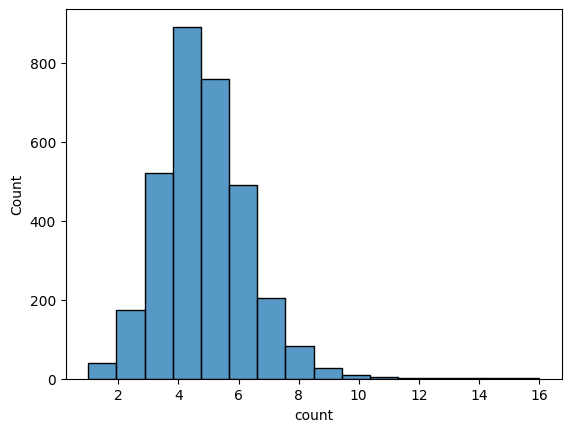

In [30]:
sns.histplot(data_arc['key'].value_counts(), bins=16)
mode = stats.mode(data_arc['key'].value_counts())
print('Mode is: ', mode[0])

Количество итераций обработки варьируется от 1 до 16 с модой, равной 4.

In [31]:
def draw(data, colmn, title, xlabel):

	fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.9, .1)}, figsize=(10, 5))

	sns.distplot(x=data[colmn], ax=ax_hist)
	sns.boxplot(x=data[colmn], ax=ax_box)
	ax_hist.axvline(np.mean(data[colmn]),color='g', 	linestyle='--', label='Среднее')
	ax_hist.axvline(np.median(data[colmn]),color='g', linestyle='-', label='Медиана')
	ax_box.set(xlabel=xlabel)
	ax_hist.set(ylabel='Count')
	ax_hist.set(title=title)
	ax_hist.legend()
	plt.show()

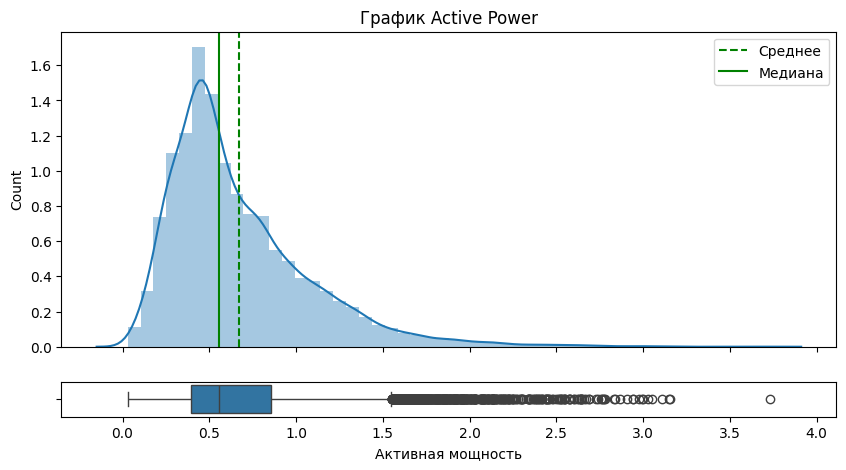

In [32]:
draw(data_arc, 'activepower', 'График Active Power', 'Активная мощность')

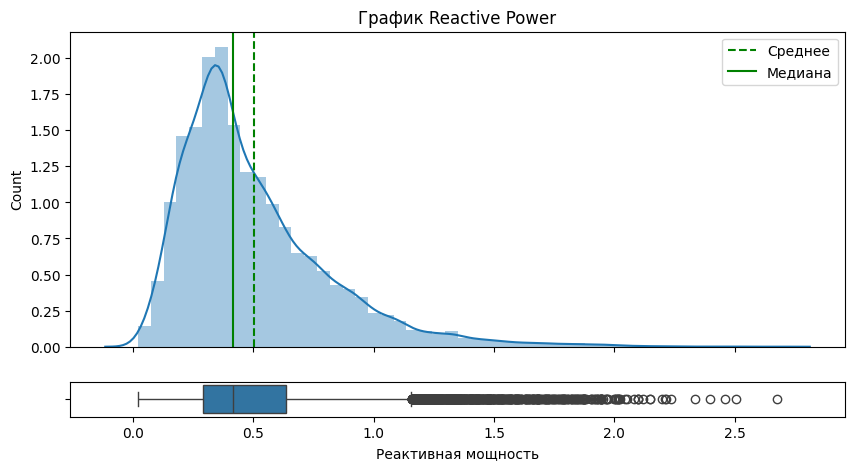

In [33]:
draw(data_arc,'reactivepower', 'График Reactive Power', 'Реактивная мощность')

        Цепи переменного напряжения имеют три вида мощности – активная, реактивная, полная. Активная энергия, как и в цепях постоянного тока, выполняет полезную работу. Реактивная – не выполняет ничего полезного, а только снижает КПД сети, греет провода, грузит генератор.
        Поскольку задача - уменьшить потребление электроэнергии, нужно обратить внимание на потери, о которых говорит коэффициент мощности, считающийся, как отношение активной мощности к полной. Чем он больше, тем меньшим током при заданном напряжении можно совершить работу.
        Введём параметр полной мощности.

In [34]:
def power(ap, rp):
    return math.sqrt(ap**2+rp**2)

In [35]:
data_arc['power'] = data_arc.apply(lambda x: power(x['activepower'], x['reactivepower']), axis=1)

In [36]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14872 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14872 non-null  int64  
 1   beginheat      14872 non-null  object 
 2   endheat        14872 non-null  object 
 3   activepower    14872 non-null  float64
 4   reactivepower  14872 non-null  float64
 5   power          14872 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 813.3+ KB


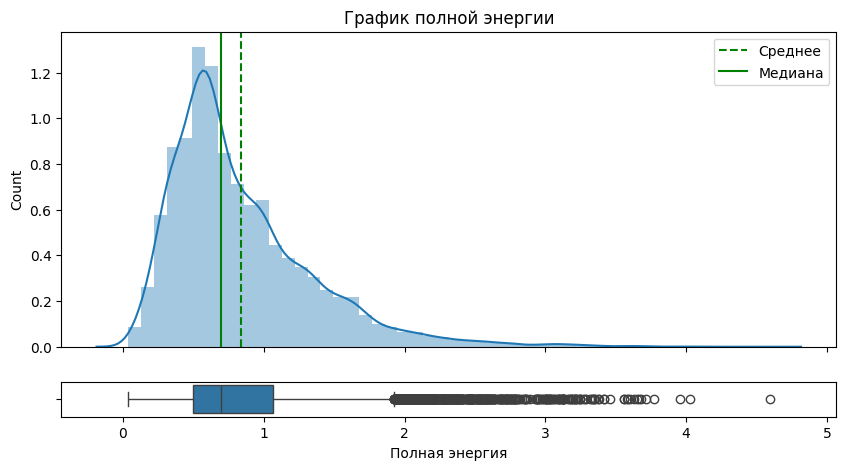

In [37]:
draw(data_arc,'power', 'График полной энергии', 'Полная энергия')

И введём параметр кооэффициента пропорциональности между активной и полной мощностями, обозначив его CosFi.

In [38]:
data_arc['cos_fi'] = data_arc['activepower']/data_arc['power']

In [39]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14872 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14872 non-null  int64  
 1   beginheat      14872 non-null  object 
 2   endheat        14872 non-null  object 
 3   activepower    14872 non-null  float64
 4   reactivepower  14872 non-null  float64
 5   power          14872 non-null  float64
 6   cos_fi         14872 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 929.5+ KB


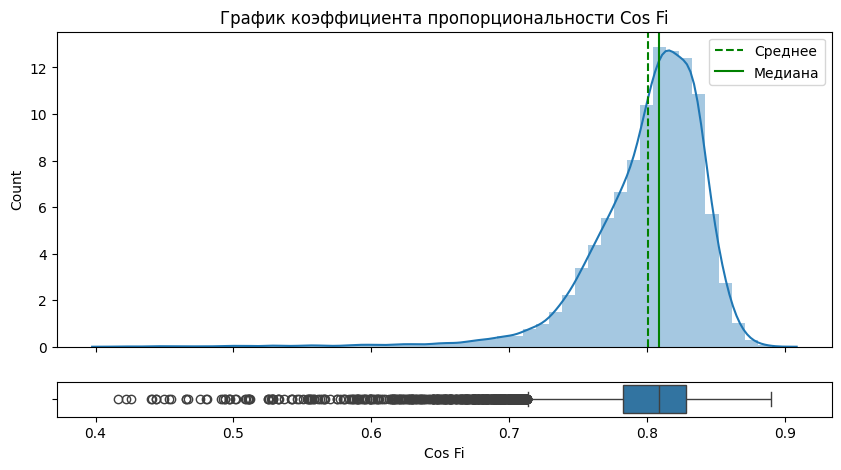

In [40]:
draw(data_arc,'cos_fi', 'График коэффициента пропорциональности Cos Fi', 'Cos Fi')


Получим время нагрева.

In [41]:
# Преобразование в секунды
def to_time(t):
    return t.hour*3600+t.minute*60 + t.second

In [42]:
def to_sec(t1, t2):
    t1 = to_time(t1)
    t2 = to_time(t2)
    # Процесс может идти и ночью, поэтому нужно учесть вариант, когда начало нагрева в 23 часа, а окончание - в 0 часов.
    if t1 < t2:
        t1 = t1 + 86400  # 86400 - количество секунд в сутках
    return t1-t2

In [43]:
data_arc['timeheat'] = data_arc.apply(lambda x: to_sec(x['endheat'],x['beginheat']), axis=1)

In [44]:
data_arc.head(5)

,key,beginheat,endheat,activepower,reactivepower,power,cos_fi,timeheat
0,1,11:02:14,11:06:02,0.98,0.69,1.19,0.82,228
1,1,11:07:28,11:10:33,0.81,0.52,0.96,0.84,185
2,1,11:11:44,11:14:36,0.74,0.50,0.90,0.83,172
3,1,11:18:14,11:24:19,1.66,1.06,1.97,0.84,365
4,1,11:26:09,11:28:37,0.69,0.41,0.81,0.86,148


In [45]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14872 entries, 0 to 14875
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14872 non-null  int64  
 1   beginheat      14872 non-null  object 
 2   endheat        14872 non-null  object 
 3   activepower    14872 non-null  float64
 4   reactivepower  14872 non-null  float64
 5   power          14872 non-null  float64
 6   cos_fi         14872 non-null  float64
 7   timeheat       14872 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 1.0+ MB


In [46]:
data_arc.describe()

,key,activepower,reactivepower,power,cos_fi,timeheat
count,14872.00,14872.00,14872.00,14872.00,14872.00,14872.00
mean,1615.09,0.67,0.50,0.84,0.80,171.69
std,934.66,0.41,0.31,0.51,0.04,98.19
min,1.00,0.03,0.02,0.04,0.42,11.00
25%,806.00,0.40,0.29,0.50,0.78,107.00
50%,1616.00,0.56,0.42,0.69,0.81,147.00
75%,2429.00,0.86,0.64,1.07,0.83,214.00
max,3241.00,3.73,2.68,4.59,0.89,907.00


Понятно, это связано с переходом через полночь. Исправить эти значения можно прибавлением 86400 секунд.

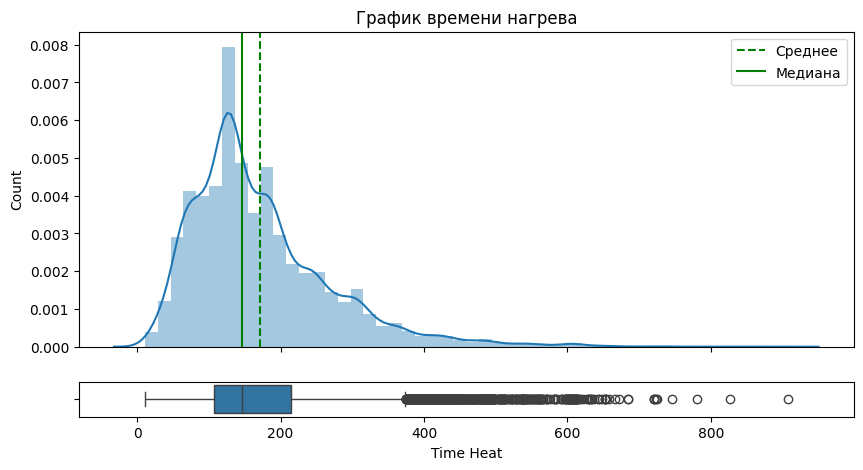

In [47]:
draw(data_arc,'timeheat', 'График времени нагрева', 'Time Heat')

Нужно подумать, какие параметры взять в работу. Косинус не получится сложить друг с другом, но энергию и время вполне можно. Оставм Время нагрева, общую энергию и Активную энергию. Тогда эти данные можно просуммировать по номеру партии и создать новую таблицу.

In [48]:
data_arc_sum = pd.pivot_table(data_arc,
               index=['key'],
               values=['activepower', 'power', 'timeheat'],
               aggfunc=sum)

Также добавим информацию о количестве итераций.

In [49]:
data_arc_sum['count'] = data_arc.groupby('key')['key'].count()

In [50]:
data_arc_sum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3213 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   activepower  3213 non-null   float64
 1   power        3213 non-null   float64
 2   timeheat     3213 non-null   int64  
 3   count        3213 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 125.5 KB


In [51]:
data_arc_sum.describe()

,activepower,power,timeheat,count
count,3213.00,3213.00,3213.00,3213.00
mean,3.10,3.88,794.69,4.63
std,1.40,1.74,332.44,1.61
min,0.19,0.26,57.00,1.00
25%,2.13,2.68,571.00,4.00
50%,2.99,3.75,770.00,4.00
75%,3.90,4.86,983.00,6.00
max,17.50,21.56,4189.00,16.00


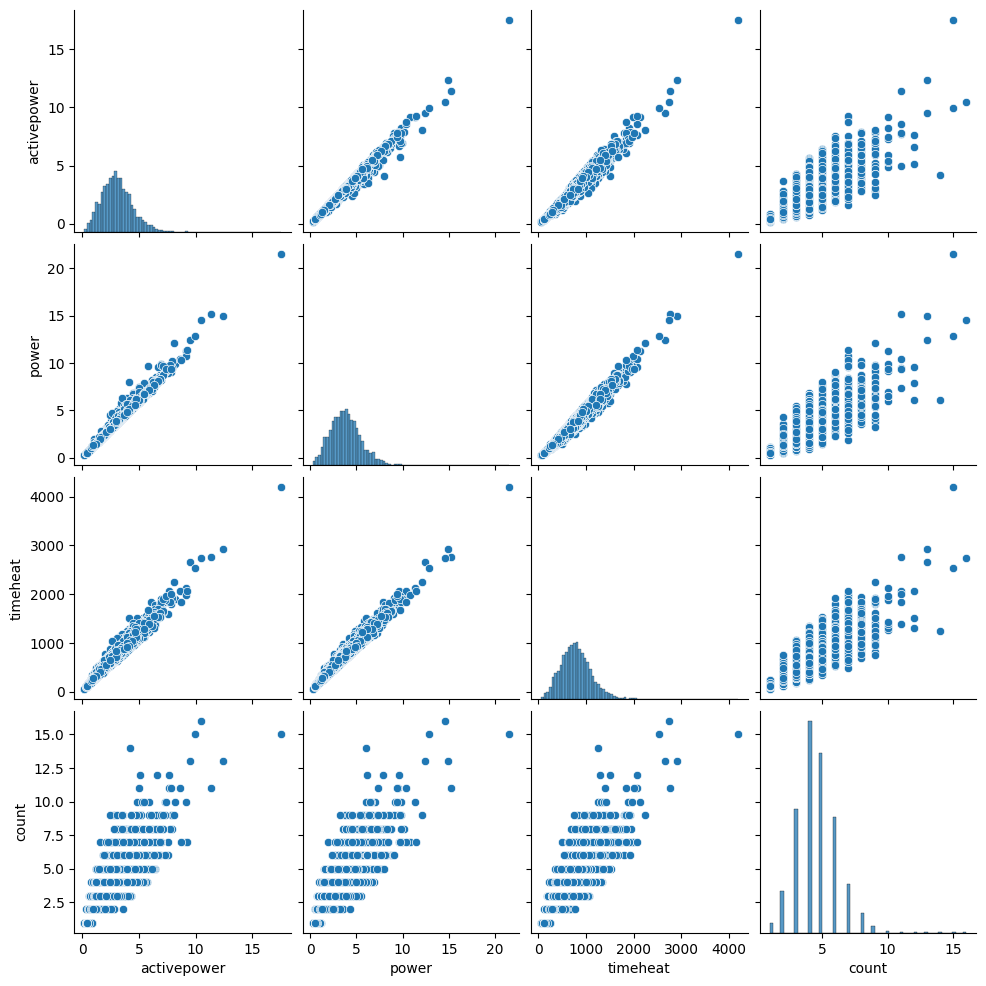

In [52]:
sns.pairplot(data_arc_sum)

<Axes: ylabel='timeheat'>

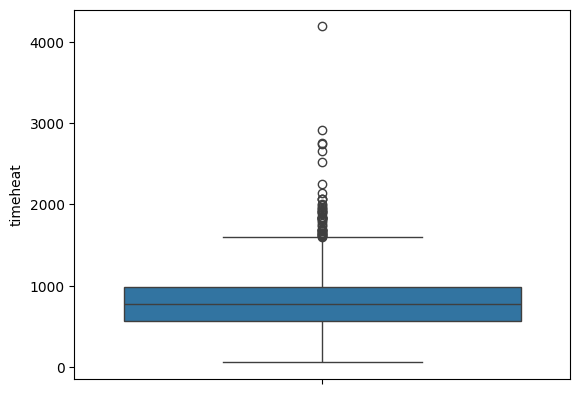

In [53]:
sns.boxplot(data_arc_sum['timeheat'])

Посмотрим на выбивающееся значение.

In [54]:
data_arc_sum[data_arc_sum['timeheat']>3000]

,activepower,power,timeheat,count
key,,,,
1689,17.50,21.56,4189,15


In [55]:
data_arc[data_arc['key']==1689]

,key,beginheat,endheat,activepower,reactivepower,power,cos_fi,timeheat
7793,1689,15:25:34,15:27:11,0.34,0.24,0.42,0.81,97
7794,1689,15:30:19,15:35:41,1.23,0.81,1.47,0.84,322
7795,1689,15:39:06,15:43:49,1.21,0.85,1.48,0.82,283
7796,1689,15:51:04,15:54:19,0.86,0.56,1.02,0.84,195
7797,1689,15:59:13,16:01:30,0.61,0.39,0.72,0.84,137
7798,1689,18:41:20,18:46:25,1.17,1.00,1.54,0.76,305
7799,1689,18:49:03,19:04:10,3.73,2.68,4.59,0.81,907
7800,1689,19:57:33,20:08:31,2.86,2.15,3.58,0.80,658
7801,1689,20:09:54,20:20:02,2.64,1.82,3.21,0.82,608
7802,1689,21:23:27,21:25:32,0.52,0.40,0.65,0.79,125


Тут вопрос к технологии - множественные добавки на протяжении некоторого времени - нормально или нет. На графике повыше есть распределение количества добавлений. Возможно, стоит ограничиться партиями в пределах 10 добавлений, но может быть, многократные добавления расходуют больше электричества, и заказчику следует обратить внимание на причину появления этих партий, для которых приходится производить многократные коррекции сплава.

Создадим две таблицы - начальная температура, конечная температура.

In [56]:
data_begin_arc = pd.pivot_table(data_arc,
               index=['key'],
               values=['beginheat'],
               aggfunc=[min])

In [57]:
data_end_arc = pd.pivot_table(data_arc,
               index=['key'],
               values=['endheat'],
               aggfunc=[max])

In [58]:
data_begin_arc.columns = ['beginheat']

In [59]:
data_end_arc.columns = ['endheat']

In [60]:
data_arc_sum = pd.merge(data_arc_sum,data_begin_arc, on=['key'])

In [61]:
data_arc_sum = pd.merge(data_arc_sum,data_end_arc, on=['key'])

In [62]:
data_arc_sum.head()

,activepower,power,timeheat,count,beginheat,endheat
key,,,,,,
1,4.88,5.83,1098,5,11:02:14,11:28:37
2,3.05,3.65,811,4,11:34:14,11:53:18
3,2.53,2.99,655,5,12:06:54,12:32:19
4,3.21,3.81,741,4,12:39:37,12:57:50
5,3.35,4.04,869,4,13:11:13,13:33:55


In [63]:
columns = ['beginheat', 'endheat']

In [64]:
for col in columns:
    data_arc_sum[col] = pd.to_datetime(data_arc_sum[col], format='%H:%M:%S')

In [65]:
data_arc_sum['duration'] = data_arc_sum['endheat'] - data_arc_sum['beginheat']

In [66]:
data_arc_sum['dur_sec'] = data_arc_sum['duration'].dt.seconds

In [67]:
data_arc_sum.head()

,activepower,power,timeheat,count,beginheat,endheat,duration,dur_sec
key,,,,,,,,
1,4.88,5.83,1098,5,1900-01-01 11:02:14,1900-01-01 11:28:37,0 days 00:26:23,1583
2,3.05,3.65,811,4,1900-01-01 11:34:14,1900-01-01 11:53:18,0 days 00:19:04,1144
3,2.53,2.99,655,5,1900-01-01 12:06:54,1900-01-01 12:32:19,0 days 00:25:25,1525
4,3.21,3.81,741,4,1900-01-01 12:39:37,1900-01-01 12:57:50,0 days 00:18:13,1093
5,3.35,4.04,869,4,1900-01-01 13:11:13,1900-01-01 13:33:55,0 days 00:22:42,1362


In [68]:
data_arc_sum['dur_sec'] = data_arc_sum.apply(lambda x: func_24(x['dur_sec']), axis=1)

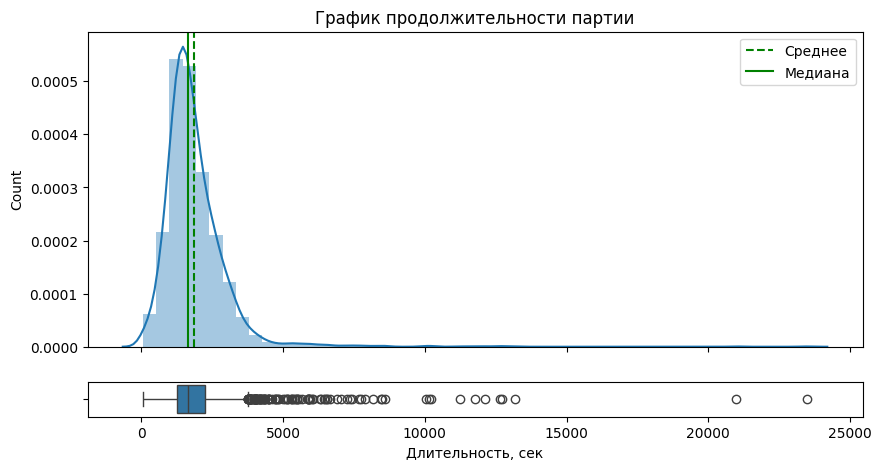

In [69]:
draw(data_arc_sum, 'dur_sec', 'График продолжительности партии', 'Длительность, сек')

In [70]:
data_arc_sum.head()

,activepower,power,timeheat,count,beginheat,endheat,duration,dur_sec
key,,,,,,,,
1,4.88,5.83,1098,5,1900-01-01 11:02:14,1900-01-01 11:28:37,0 days 00:26:23,1583
2,3.05,3.65,811,4,1900-01-01 11:34:14,1900-01-01 11:53:18,0 days 00:19:04,1144
3,2.53,2.99,655,5,1900-01-01 12:06:54,1900-01-01 12:32:19,0 days 00:25:25,1525
4,3.21,3.81,741,4,1900-01-01 12:39:37,1900-01-01 12:57:50,0 days 00:18:13,1093
5,3.35,4.04,869,4,1900-01-01 13:11:13,1900-01-01 13:33:55,0 days 00:22:42,1362


Стоит проверить, нет ли в столбце 'timeheat' значений, превышающих значения в столбце 'dur_sec'.

In [71]:
data_arc_sum['is_pos'] = (data_arc_sum['dur_sec']-data_arc_sum['timeheat'])<0

In [72]:
data_arc_sum[data_arc_sum['is_pos']==True]

,activepower,power,timeheat,count,beginheat,endheat,duration,dur_sec,is_pos
key,,,,,,,,,
45,9.18,11.29,2136,10,1900-01-01 00:09:50,1900-01-01 23:40:21,0 days 23:30:31,631,True
46,12.36,14.93,2919,13,1900-01-01 00:00:02,1900-01-01 23:53:27,0 days 23:53:25,2005,True
280,7.79,9.10,1807,9,1900-01-01 00:05:53,1900-01-01 23:55:05,0 days 23:49:12,1752,True
642,7.58,9.68,1970,7,1900-01-01 00:07:38,1900-01-01 23:51:15,0 days 23:43:37,1417,True
1263,4.41,5.28,961,5,1900-01-01 00:19:00,1900-01-01 23:45:12,0 days 23:26:12,372,True
1516,5.70,7.12,1504,8,1900-01-01 00:19:38,1900-01-01 23:52:24,0 days 23:32:46,766,True
2439,7.12,8.71,1648,8,1900-01-01 00:07:54,1900-01-01 23:46:38,0 days 23:38:44,1124,True
2468,1.36,1.71,347,2,1900-01-01 00:34:32,1900-01-01 00:37:46,0 days 00:03:14,194,True


Нам известно о несогласованности времени на датчиках, поэтому просто посмотрим на это.

In [74]:
for key in key_drop:
    data_arc_sum = data_arc_sum[data_arc_sum.index != key]

In [75]:
data_arc_sum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3213 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   activepower  3213 non-null   float64        
 1   power        3213 non-null   float64        
 2   timeheat     3213 non-null   int64          
 3   count        3213 non-null   int64          
 4   beginheat    3213 non-null   datetime64[ns] 
 5   endheat      3213 non-null   datetime64[ns] 
 6   duration     3213 non-null   timedelta64[ns]
 7   dur_sec      3213 non-null   int64          
 8   is_pos       3213 non-null   bool           
dtypes: bool(1), datetime64[ns](2), float64(2), int64(3), timedelta64[ns](1)
memory usage: 229.1 KB


Первые данные готовы.

####     Для таблицы steel.data_bulk:
        Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
        Обработайте пропуски. Пропуск означает, что материал не добавляли в партию.



In [76]:
df_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,count,mean,std,min,25%,50%,75%,max
key,3129.00,1624.38,933.34,1.00,816.00,1622.00,2431.00,3241.00
Bulk 1,252.00,39.24,18.28,10.00,27.00,31.00,46.00,185.00
Bulk 2,22.00,253.05,21.18,228.00,242.00,251.50,257.75,325.00
Bulk 3,1298.00,113.88,75.48,6.00,58.00,97.50,152.00,454.00
Bulk 4,1014.00,104.39,48.18,12.00,72.00,102.00,133.00,281.00
Bulk 5,77.00,107.03,81.79,11.00,70.00,86.00,132.00,603.00
Bulk 6,576.00,118.93,72.06,17.00,69.75,100.00,157.00,503.00
Bulk 7,25.00,305.60,191.02,47.00,155.00,298.00,406.00,772.00
Bulk 8,1.00,49.00,NaN,49.00,49.00,49.00,49.00,49.00
Bulk 9,19.00,76.32,21.72,63.00,66.00,68.00,70.50,147.00


Хаотичное заполнение. Пропуски можно заменить на нули. Названия колонок привести к другому формату.
Добавление сыпучего материала номер 8 было сделано всего в одной партии. Возможно, эту партию стоит удалить из рассмотрения.

In [77]:
data_bulk.columns = data_bulk.columns.str.lower()
data_bulk.columns = data_bulk.columns.str.replace(" ", "_")

In [78]:
data_bulk = data_bulk.fillna(0)

In [79]:
data_bulk['key'].duplicated().sum()

0

Нет строк с одинаковыми номерами партий.

In [80]:
data_bulk.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.00,0.00,0.00,43.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,150.00,154.00
1,2,0.00,0.00,0.00,73.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,149.00,154.00
2,3,0.00,0.00,0.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,205.00,0.00,152.00,153.00
3,4,0.00,0.00,0.00,81.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,207.00,0.00,153.00,154.00
4,5,0.00,0.00,0.00,78.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,0.00,151.00,152.00


In [81]:
data_bulk[data_bulk['bulk_8']!=0]

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1725,1786,0.00,0.00,123.00,0.00,0.00,0.00,0.00,49.00,147.00,0.00,0.00,0.00,0.00,0.00,0.00


In [82]:
key_drop.append(list(data_bulk[data_bulk['bulk_8']!=0]['key'])[0])

In [83]:
key_drop

[2116, 1786]

In [84]:
for key in key_drop:
    data_bulk = data_bulk[data_bulk['key'] != key]

In [85]:
df_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
Index: 3127 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3127 non-null   int64  
 1   bulk_1   3127 non-null   float64
 2   bulk_2   3127 non-null   float64
 3   bulk_3   3127 non-null   float64
 4   bulk_4   3127 non-null   float64
 5   bulk_5   3127 non-null   float64
 6   bulk_6   3127 non-null   float64
 7   bulk_7   3127 non-null   float64
 8   bulk_8   3127 non-null   float64
 9   bulk_9   3127 non-null   float64
 10  bulk_10  3127 non-null   float64
 11  bulk_11  3127 non-null   float64
 12  bulk_12  3127 non-null   float64
 13  bulk_13  3127 non-null   float64
 14  bulk_14  3127 non-null   float64
 15  bulk_15  3127 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 415.3 KB


None

,count,mean,std,min,25%,50%,75%,max
key,3127.00,1624.17,933.59,1.00,815.50,1621.00,2431.50,3241.00
bulk_1,3127.00,3.16,11.87,0.00,0.00,0.00,0.00,185.00
bulk_2,3127.00,1.78,21.22,0.00,0.00,0.00,0.00,325.00
bulk_3,3127.00,47.23,74.25,0.00,0.00,0.00,79.50,454.00
bulk_4,3127.00,33.85,56.05,0.00,0.00,0.00,68.00,281.00
bulk_5,3127.00,2.64,20.92,0.00,0.00,0.00,0.00,603.00
bulk_6,3127.00,21.86,55.47,0.00,0.00,0.00,0.00,503.00
bulk_7,3127.00,2.44,31.95,0.00,0.00,0.00,0.00,772.00
bulk_8,3127.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
bulk_9,3127.00,0.42,5.57,0.00,0.00,0.00,0.00,111.00


In [86]:
data_bulk = data_bulk.drop(['bulk_8'], axis=1)

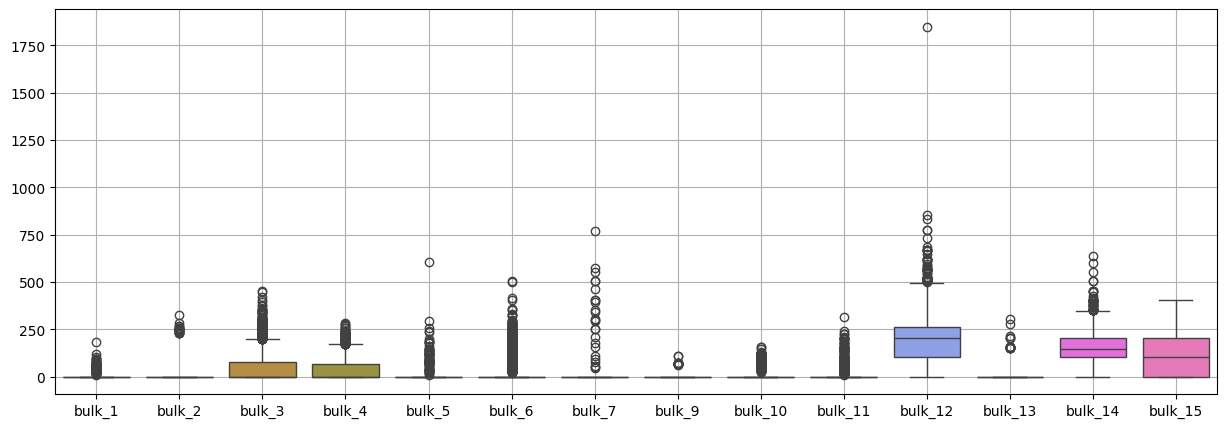

In [87]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_bulk.drop(['key'], axis=1))
plt.grid();

Чаще всего добавление сыпучих материалов идёт на этапе 3,4, 12,14 и 15.

In [88]:
data_bulk[data_bulk['bulk_12']>1000]

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
303,322,185.00,0.00,101.00,58.00,0.00,0.00,406.00,0.00,0.00,0.00,1849.00,0.00,636.00,0.00


В этой партии самая массивная добавка на 12 этапе. Нельзя гарантированно утверждать, что это неверно, но можно эту партию исключить.

Получим сумму объёмов сыпучих материалов для каждой партии и посмотрим, насколько велик там разброс.

In [91]:
data_bulk['sum_bulk'] = data_bulk.drop(['key'], axis=1).apply(['sum'], axis=1)

In [92]:
data_bulk.sample(10)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk
2474,2566,34.00,258.00,0.00,74.00,120.00,0.00,298.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,784.00
2171,2250,0.00,0.00,0.00,147.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,147.00
2073,2145,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,463.00,0.00,197.00,210.00,870.00
726,759,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,76.00,0.00,368.00,0.00,225.00,189.00,858.00
2817,2923,0.00,0.00,0.00,86.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,110.00,108.00,510.00
851,887,44.00,0.00,280.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,516.00,0.00,282.00,103.00,1225.00
1572,1631,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,256.00,0.00,120.00,206.00,582.00
1525,1583,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,139.00,0.00,139.00
1781,1843,0.00,0.00,0.00,122.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,122.00
1147,1195,0.00,0.00,151.00,79.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,103.00,103.00,642.00


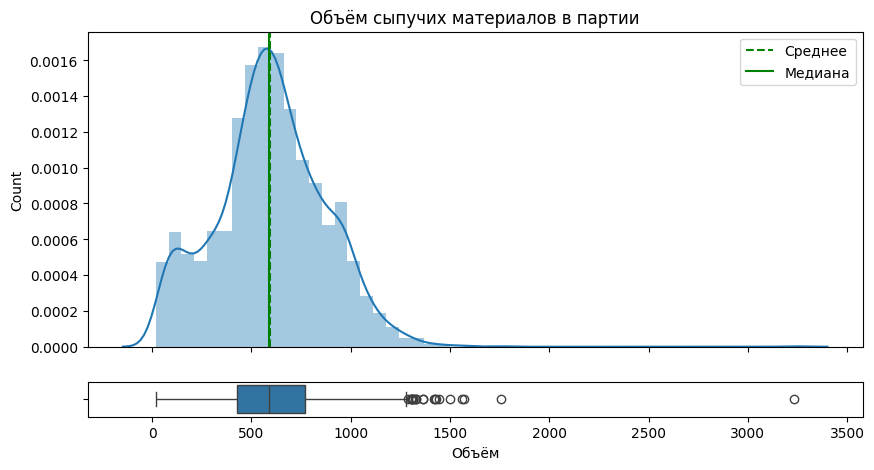

In [93]:
draw(data_bulk,'sum_bulk', 'Объём сыпучих материалов в партии', 'Объём')

In [94]:
data_bulk['sum_bulk'].describe()

count   3127.00
mean     595.68
std      276.56
min       19.00
25%      429.00
50%      591.00
75%      772.50
max     3235.00
Name: sum_bulk, dtype: float64

Получается, что распределение довольно компактное.

####     Для таблицы steel.data_bulk_time:
        Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
        Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.
   

In [96]:
df_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,count,mean,std,min,25%,50%,75%,max
key,3129.00,1624.38,933.34,1.00,816.00,1622.00,2431.00,3241.00


Соответствует предыдущей таблице.

In [97]:
data_bulk_time.columns = data_bulk_time.columns.str.lower()
data_bulk_time.columns = data_bulk_time.columns.str.replace(" ", "_")

In [98]:
data_bulk_time.head(5)


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


Преобразую это время в секунды.

In [99]:
data_bulk_time = data_bulk_time.drop(['bulk_8'], axis=1)

In [100]:
data_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15'],
      dtype='object')

In [101]:
columns = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

In [102]:
for col in columns:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col], format='%H:%M:%S')

In [103]:
def row_time(row):
    a = []
    for i in range(1, len(row)):
        if pd.notnull(row[i]):
            a.append(row[i])
    return max(a)-min(a)  

In [104]:
data_bulk_time['bulk_dur'] = data_bulk_time.apply(lambda x: row_time(x), axis=1)

In [105]:
data_bulk_time['bulk_dur'] .describe()

count                         3129
mean     0 days 00:19:16.337168424
std      0 days 01:57:39.209055339
min                0 days 00:00:00
25%                0 days 00:03:31
50%                0 days 00:06:54
75%                0 days 00:12:24
max                0 days 23:56:38
Name: bulk_dur, dtype: object

 У нас нет точных данных о том, в какой последовательности нужно добавлять материалы, возможно, это не важно, и нет никаких предписаний на очерёдность добавок. За номерами (bulk_1 - bulk_15) кроется не очерёдность, а материал добавки. 

In [106]:
data_bulk_time['dur_sec'] = data_bulk_time['bulk_dur'].dt.seconds

In [107]:
data_bulk_time.head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_dur,dur_sec
0,1,NaT,NaT,NaT,1900-01-01 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:03:52,NaT,1900-01-01 11:03:52,1900-01-01 11:03:52,0 days 00:17:38,1058
1,2,NaT,NaT,NaT,1900-01-01 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:40:20,NaT,1900-01-01 11:40:20,1900-01-01 11:40:20,0 days 00:06:18,378
2,3,NaT,NaT,NaT,1900-01-01 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 12:09:40,NaT,1900-01-01 12:09:40,1900-01-01 12:09:40,0 days 00:21:26,1286
3,4,NaT,NaT,NaT,1900-01-01 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 12:41:24,NaT,1900-01-01 12:41:24,1900-01-01 12:41:24,0 days 00:07:19,439
4,5,NaT,NaT,NaT,1900-01-01 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 13:12:56,NaT,1900-01-01 13:12:56,1900-01-01 13:12:56,0 days 00:05:54,354


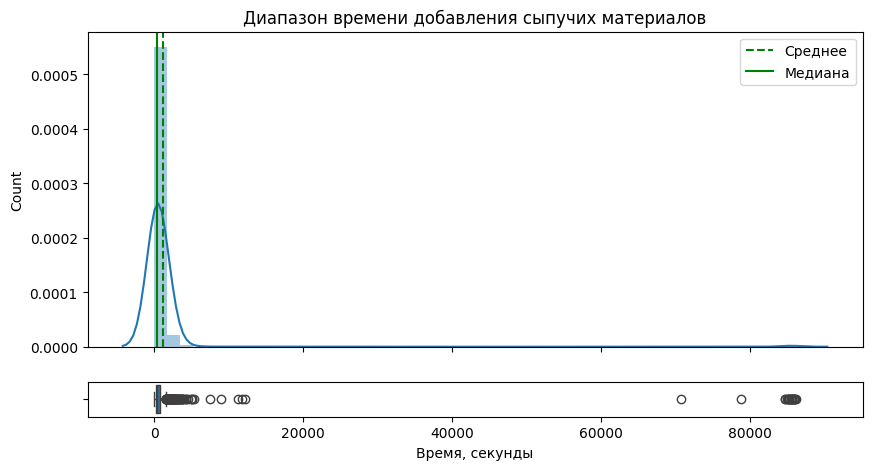

In [108]:
draw(data_bulk_time, 'dur_sec', 'Диапазон времени добавления сыпучих материалов', 'Время, секунды')

При попытке учесть направление туда и обратно всё равно видим некоторые партии с большой протяжённостью по времени добавления материала. Посмотрим их, скорее всего, тут что-то не так с вычислениями

In [109]:
data_bulk_time[data_bulk_time['dur_sec']>20000]

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_dur,dur_sec
41,44,NaT,NaT,NaT,NaT,NaT,1900-01-01 22:33:48,NaT,NaT,NaT,NaT,1900-01-01 00:39:35,1900-01-01 00:39:35,1900-01-01 22:15:42,1900-01-01 00:39:35,0 days 21:54:13,78853
64,74,NaT,NaT,NaT,1900-01-01 00:01:50,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:53:27,NaT,1900-01-01 23:53:27,1900-01-01 23:53:27,0 days 23:51:37,85897
113,126,NaT,NaT,1900-01-01 00:00:01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:46:55,NaT,1900-01-01 23:46:55,1900-01-01 23:46:55,0 days 23:46:54,85614
216,232,NaT,NaT,NaT,NaT,1900-01-01 00:01:33,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:50:13,NaT,1900-01-01 23:50:13,1900-01-01 23:50:13,0 days 23:48:40,85720
263,280,NaT,NaT,1900-01-01 23:51:46,NaT,NaT,NaT,NaT,1900-01-01 00:04:56,NaT,NaT,1900-01-01 23:23:23,NaT,1900-01-01 23:23:23,NaT,0 days 23:46:50,85610
614,641,NaT,NaT,NaT,1900-01-01 01:03:12,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 20:42:03,1900-01-01 20:42:03,NaT,1900-01-01 20:42:03,0 days 19:38:51,70731
615,642,NaT,NaT,NaT,1900-01-01 00:22:47,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:56:15,NaT,1900-01-01 23:56:15,1900-01-01 23:56:15,0 days 23:33:28,84808
880,913,NaT,NaT,1900-01-01 00:12:43,NaT,NaT,1900-01-01 00:12:43,NaT,NaT,NaT,NaT,1900-01-01 23:57:38,NaT,1900-01-01 23:57:38,NaT,0 days 23:44:55,85495
955,999,NaT,NaT,1900-01-01 00:04:29,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:56:29,NaT,1900-01-01 23:56:29,1900-01-01 23:56:29,0 days 23:52:00,85920
1037,1082,NaT,NaT,NaT,1900-01-01 00:00:38,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 23:39:05,NaT,1900-01-01 23:39:05,1900-01-01 23:39:05,0 days 23:38:27,85107


Это ночные партии, и у них надо учесть сутки.

In [110]:
data_bulk_time['dur_secnd'] = data_bulk_time.apply(lambda x: func_24(x['dur_sec']), axis=1)

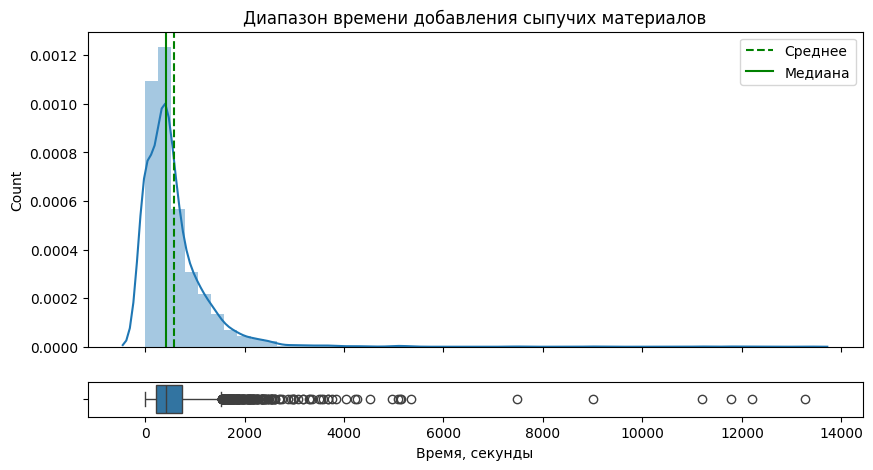

In [111]:
draw(data_bulk_time,'dur_secnd','Диапазон времени добавления сыпучих материалов','Время, секунды')

In [112]:
data_bulk_time.sample(4)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_dur,dur_sec,dur_secnd
347,372,NaT,NaT,1900-01-01 10:38:29,NaT,NaT,NaT,NaT,NaT,1900-01-01 10:38:29,NaT,1900-01-01 10:27:42,NaT,1900-01-01 10:27:42,1900-01-01 10:27:42,0 days 00:10:47,647,647
1979,2048,NaT,NaT,NaT,1900-01-01 11:58:23,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:53:04,NaT,1900-01-01 11:53:04,1900-01-01 11:53:04,0 days 00:05:19,319,319
2947,3056,NaT,NaT,1900-01-01 06:00:43,1900-01-01 06:00:43,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 05:52:29,NaT,1900-01-01 05:52:29,1900-01-01 05:52:29,0 days 00:08:14,494,494
2047,2116,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:39:50,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 00:35:59,NaT,0 days 00:03:51,231,231


Поскольку на самом деле мы ничего не можем сказать про время добавления материалов, как оно влияет на процесс получения сплава, то и брать этот параметр в модель, наверное, не надо. К тому же, заказчик нам всё-таки сообщает, что датчики времени могут быть не синхронизированы, поэтому нет смысла искать связь этих данных со всем процессом без знаний о рассинхронизации.

####     Для таблицы steel.data_gas:
        Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
    

In [113]:
df_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,count,mean,std,min,25%,50%,75%,max
key,3239.00,1621.86,935.39,1.00,812.50,1622.00,2431.50,3241.00
gas,3239.00,11.00,6.22,0.01,7.04,9.84,13.77,78.00


In [114]:
for key in key_drop:
    data_gas = data_gas[data_gas['key'] != key]

Без пропусков.

In [115]:
data_gas.head(4)

,key,gas
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84


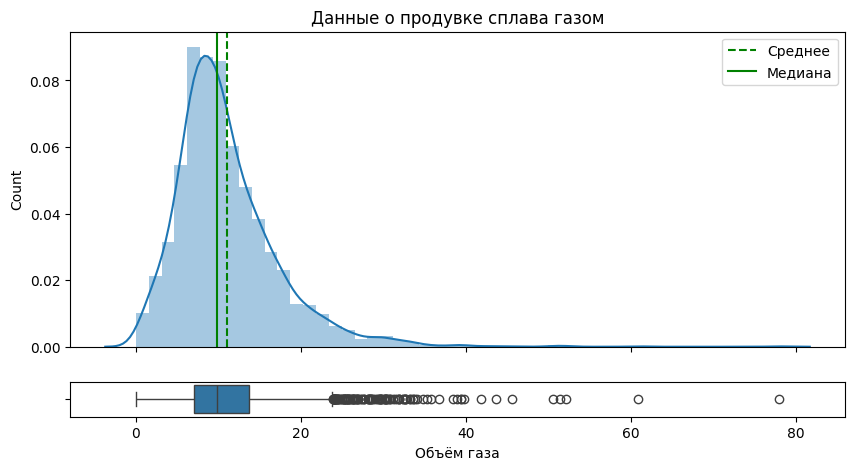

In [116]:
draw(data_gas,'gas','Данные о продувке сплава газом','Объём газа')

####     Для таблицы steel.data_temp:
        Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределения признаков.
        Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.
        При агрегировании наблюдений используйте только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.
        Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные.


In [117]:
df_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,count,mean,std,min,25%,50%,75%,max
key,15907.00,1607.88,942.21,1.00,790.00,1618.00,2427.00,3241.00
Temperature,13006.00,1591.84,21.38,1191.00,1581.00,1591.00,1601.00,1705.00


In [118]:
data_temp.columns = data_temp.columns.str.lower()


In [119]:
first_len = len(data_temp['key'].unique())

Не всегда измеряли температуру.
Для начала исключим партии, в которых температура ниже 1500 градусов.

In [120]:
low_temp = data_temp[data_temp['temperature']<=1500]

In [121]:
low_temp

,key,mesauretime,temperature
4350,867,14:21:00,1191.00
5978,1214,05:32:00,1208.00
7958,1619,11:03:54,1218.00
8913,1818,00:30:49,1383.00
8914,1818,00:31:40,1383.00
10127,2052,14:51:40,1227.00
12564,2561,07:34:15,1204.00


In [122]:
key_drop.extend(list(low_temp['key'].unique()))

In [123]:
key_drop

[2116, 1786, 867, 1214, 1619, 1818, 2052, 2561]

Удалим все партии с номерами из этого списка, чтоб не тратить на них время.

In [124]:
for key in key_drop:
    data_temp = data_temp[data_temp['key'] != key]

In [125]:
df_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
Index: 15849 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15849 non-null  int64  
 1   mesauretime  15849 non-null  object 
 2   temperature  12953 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 495.3+ KB


None

,count,mean,std,min,25%,50%,75%,max
key,15849.00,1607.72,943.47,1.00,787.00,1616.00,2429.00,3241.00
temperature,12953.00,1591.97,19.79,1519.00,1581.00,1591.00,1601.00,1705.00


In [126]:
data_temp[data_temp['key'] == 3179]

,key,mesauretime,temperature
15640,3179,03:29:45,1618.00
15641,3179,03:36:36,NaN
15642,3179,03:44:51,NaN


Теперь посмотрим, в скольки партиях отсутствуют измерения.

In [127]:
no_temp = data_temp[data_temp['temperature'].isna()]

In [128]:
print('Патий без измерений температуры:',len(no_temp['key'].unique()))
print('Патий без измерений температуры в процентах:', round(len(no_temp['key'].unique())*100/first_len, 2), '%')    

Патий без измерений температуры: 738
Патий без измерений температуры в процентах: 22.95 %


Многовато. Тогда попробуем оставить те, в которых нет промежуточных измерений, а первое и последнее есть. Те партии, в которых не первого и последнего измерений, придётся удалить, как бы много их ни было.

Создадим две таблицы - начальная температура, конечная температура.

In [129]:
data_begin_temp = pd.pivot_table(data_temp,
               index=['key'],
               values=['mesauretime'],
               aggfunc=[min])

In [130]:
data_end_temp = pd.pivot_table(data_temp,
               index=['key'],
               values=['mesauretime'],
               aggfunc=[max])

In [131]:
data_end_temp.columns = ['mesauretime']

In [132]:
data_begin_temp.columns = ['mesauretime']

In [133]:
data_begin_temp

,mesauretime
key,
1,11:16:18
2,11:37:27
3,12:13:17
4,12:52:57
5,13:23:19
...,...
3237,22:44:04
3238,23:30:31
3239,01:31:47


In [134]:
data_begin_temp = pd.merge(data_begin_temp, data_temp, on=['key','mesauretime'], how='left')

In [135]:
data_begin_temp

,key,mesauretime,temperature
0,1,11:16:18,1571.00
1,2,11:37:27,1581.00
2,3,12:13:17,1596.00
3,4,12:52:57,1601.00
4,5,13:23:19,1576.00
...,...,...,...
3203,3237,22:44:04,1569.00
3204,3238,23:30:31,1584.00
3205,3239,01:31:47,1598.00
3206,3240,02:39:01,1617.00


In [136]:
data_end_temp = pd.merge(data_end_temp, data_temp, on=['key','mesauretime'], how='left')

In [137]:
data_end_temp

,key,mesauretime,temperature
0,1,11:30:39,1613.00
1,2,11:59:12,1602.00
2,3,12:34:57,1599.00
3,4,12:59:25,1625.00
4,5,13:36:01,1602.00
...,...,...,...
3203,3237,23:05:43,NaN
3204,3238,23:43:00,NaN
3205,3239,02:24:15,NaN
3206,3240,03:35:16,NaN


Теперь обе таблицы проверим на пропуски.

In [138]:
data_begin_temp.isna().sum()

key             0
mesauretime     0
temperature    17
dtype: int64

In [139]:
data_end_temp.isna().sum()

key              0
mesauretime      0
temperature    734
dtype: int64

Выделим все номера партий с пропусками.

In [140]:
key_drop.extend(list(data_begin_temp[data_begin_temp['temperature'].isna()]['key']))

In [141]:
key_drop.extend(list(data_end_temp[data_end_temp['temperature'].isna()]['key']))

In [142]:
key_drop = set(key_drop)

In [143]:
for key in key_drop:
    data_begin_temp = data_begin_temp[data_begin_temp['key'] != key]
    data_end_temp = data_end_temp[data_end_temp['key'] != key]

In [144]:
df_info(data_begin_temp)

<class 'pandas.core.frame.DataFrame'>
Index: 2470 entries, 0 to 2469
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2470 non-null   int64  
 1   mesauretime  2470 non-null   object 
 2   temperature  2470 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


None

,count,mean,std,min,25%,50%,75%,max
key,2470.00,1248.87,720.45,1.00,626.25,1249.50,1871.75,2499.00
temperature,2470.00,1588.95,24.88,1519.00,1572.00,1588.00,1605.00,1679.00


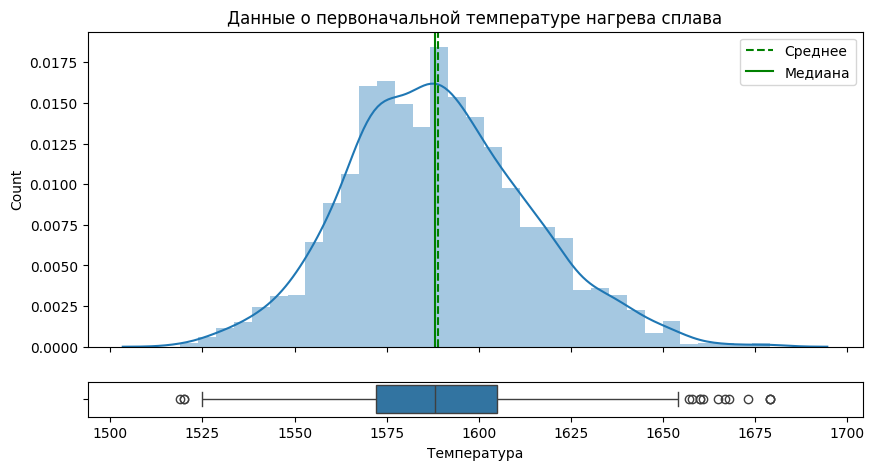

In [145]:
draw(data_begin_temp,'temperature','Данные о первоначальной температуре нагрева сплава','Температура')

In [146]:
df_info(data_end_temp)

<class 'pandas.core.frame.DataFrame'>
Index: 2470 entries, 0 to 2469
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2470 non-null   int64  
 1   mesauretime  2470 non-null   object 
 2   temperature  2470 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


None

,count,mean,std,min,25%,50%,75%,max
key,2470.00,1248.87,720.45,1.00,626.25,1249.50,1871.75,2499.00
temperature,2470.00,1595.13,16.16,1530.00,1587.00,1593.00,1599.00,1700.00


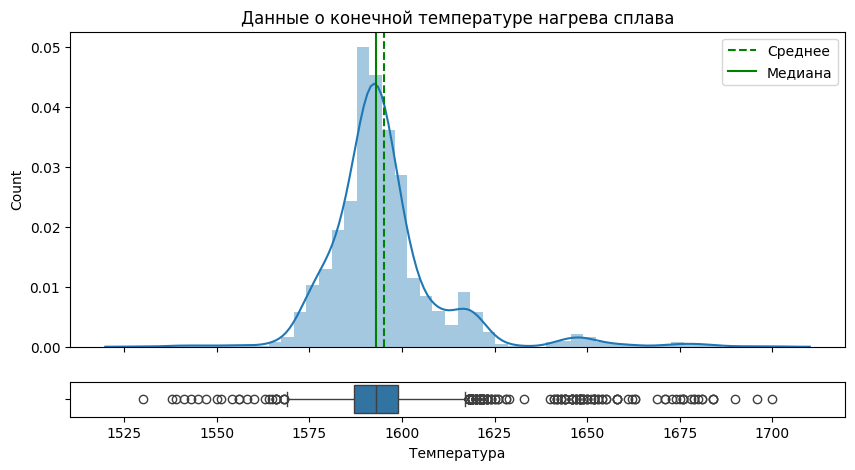

In [147]:
draw(data_end_temp,'temperature','Данные о конечной температуре нагрева сплава','Температура')

Получили таргет.

####     Для таблицы steel.data_wire:
        Обработайте пропуски. Пропуск означает, что материал не добавляли в эту партию.


In [148]:
df_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,count,mean,std,min,25%,50%,75%,max
key,3081.00,1623.43,933.00,1.00,823.00,1619.00,2434.00,3241.00
Wire 1,3055.00,100.90,42.01,1.92,72.12,100.16,126.06,330.31
Wire 2,1079.00,50.58,39.32,0.03,20.19,40.14,70.23,282.78
Wire 3,63.00,189.48,99.51,0.14,95.14,235.19,276.25,385.01
Wire 4,14.00,57.44,28.82,24.15,40.81,45.23,76.12,113.23
Wire 5,1.00,15.13,NaN,15.13,15.13,15.13,15.13,15.13
Wire 6,73.00,48.02,33.92,0.03,25.05,42.08,64.21,180.45
Wire 7,11.00,10.04,8.61,0.23,6.76,9.02,11.89,32.85
Wire 8,19.00,53.63,16.88,45.08,46.09,46.28,48.09,102.76
Wire 9,29.00,34.16,19.93,4.62,22.06,30.07,43.86,90.05


In [149]:
data_wire.columns = data_wire.columns.str.lower()
data_wire.columns = data_wire.columns.str.replace(" ", "_")

Снова много пропусков, но их можно заменить нулевыми значениями.

Сначала избавимся от тех партий, которые мы исключили в предыдущих пунктах.

In [ ]:
for key in key_drop:
    data_wire = data_wire[data_wire['key'] != key]

In [151]:
data_wire = data_wire.fillna(0)

In [152]:
data_wire = data_wire.drop(['wire_5'], axis=1)

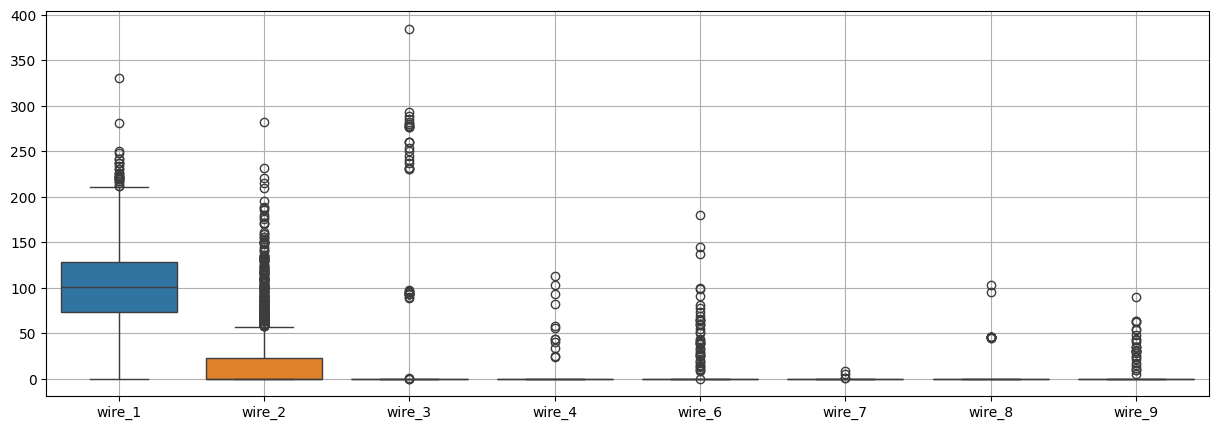

In [153]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_wire.drop(['key'], axis=1))
plt.grid();

In [154]:
data_wire['sum_wire'] = data_wire.drop(['key'], axis=1).apply(['sum'], axis=1)

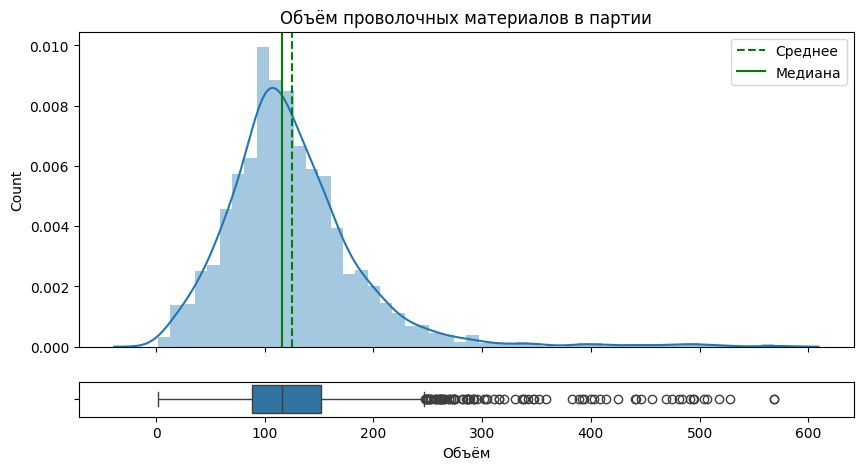

In [155]:
draw(data_wire,'sum_wire','Объём проволочных материалов в партии','Объём')

In [156]:
data_wire['sum_wire'].describe()

count   2367.00
mean     125.20
std       63.97
min        1.92
25%       88.32
50%      116.10
75%      151.60
max      568.78
Name: sum_wire, dtype: float64

####     Для таблицы steel.data_wire_time:
        Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
        Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.


In [157]:
df_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,count,mean,std,min,25%,50%,75%,max
key,3081.00,1623.43,933.00,1.00,823.00,1619.00,2434.00,3241.00


Соответствует предыдущей.

In [158]:
data_wire_time.columns = data_wire_time.columns.str.lower()
data_wire_time.columns = data_wire_time.columns.str.replace(" ", "_")

Избавимся от тех партий, которые мы исключили в предыдущих пунктах.

In [159]:
for key in key_drop:
    data_wire_time = data_wire_time[data_wire_time['key'] != key]

In [160]:
data_wire_time = data_wire_time.drop(['wire_5'], axis=1)

In [161]:
data_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9'],
      dtype='object')

In [162]:
columns = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

In [163]:
for col in columns:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col], format='%H:%M:%S')

In [164]:
data_wire_time.sample(4)

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
2154,2264,1900-01-01 16:44:45,NaT,NaT,NaT,NaT,NaT,NaT,NaT
852,905,1900-01-01 17:22:54,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2330,2455,1900-01-01 12:59:37,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1610,1689,1900-01-01 15:45:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [165]:
data_wire_time['wire_dur'] = data_wire_time.apply(lambda x: row_time(x), axis=1)

In [166]:
data_wire_time['wire_dur'].describe()

count                         2367
mean     0 days 00:05:25.204900718
std      0 days 01:05:59.276061632
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:01:19
max                0 days 23:54:06
Name: wire_dur, dtype: object

 Ничего экстраординарного не видим. 23 часа - это снова ночные партии. 

In [167]:
data_wire_time['wire_sec'] = data_wire_time['wire_dur'].dt.seconds

In [168]:
data_wire_time.head(5)

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_dur,wire_sec
0,1,1900-01-01 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00,0
1,2,1900-01-01 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00,0
2,3,1900-01-01 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00,0
3,4,1900-01-01 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00,0
4,5,1900-01-01 13:18:15,1900-01-01 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:13:51,831


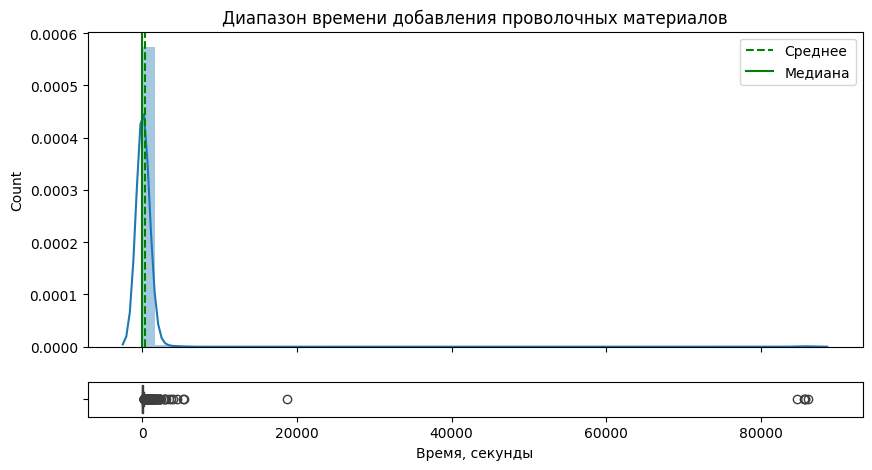

In [169]:
draw(data_wire_time,'wire_sec','Диапазон времени добавления проволочных материалов','Время, секунды')

In [170]:
data_wire_time['wire_secnd'] = data_wire_time.apply(lambda x: func_24(x['wire_sec']), axis=1)

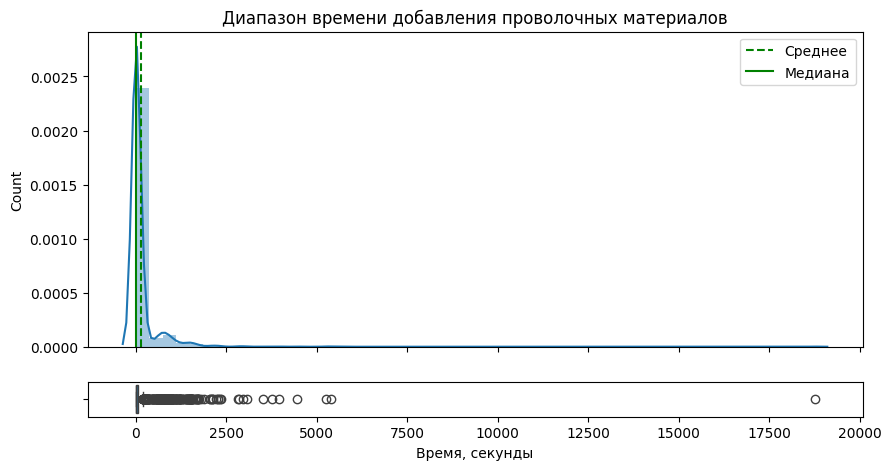

In [171]:
draw(data_wire_time,'wire_secnd','Диапазон времени добавления проволочных материалов','Время, секунды')

Посмотрим, что это за выброс.

In [172]:
data_wire_time[data_wire_time['wire_secnd']>17000]

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_dur,wire_sec,wire_secnd
2011,2108,1900-01-01 19:50:47,NaT,1900-01-01 14:43:41,1900-01-01 14:40:29,1900-01-01 14:38:11,1900-01-01 19:46:16,NaT,NaT,0 days 05:12:36,18756,18756


Как есть.

####     Объедините таблицы по ключу:
        Каждой партии должно соответствовать одно наблюдение.
        Учтите: во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался.
        Заказчик предупредил, что иногда наблюдается асинхронность в заданном времени разных датчиков. Если вы будете выстраивать хронологию процессов для разных партий, то можете столкнуться с тем, что полученная хронология не соответствует хронологии в описании. Не стоит воспринимать это как ошибку.


Прогоним ещё раз датасеты и удалим из более ранних те партии, которые мы насобирали втечение всей обработки.

In [173]:
for key in key_drop:
    data_arc_sum = data_arc_sum[data_arc_sum.index != key]
    data_bulk = data_bulk[data_bulk['key'] != key]
    data_bulk_time = data_bulk_time[data_bulk_time['key'] != key]
    data_gas = data_gas[data_gas['key'] != key]
    data_begin_temp = data_begin_temp[data_begin_temp['key'] != key]
    data_end_temp = data_end_temp[data_end_temp['key'] != key]
    data_wire = data_wire[data_wire['key'] != key]
    data_wire_time = data_wire_time[data_wire_time['key'] != key]
    

Будем объединять данные. 

In [174]:
data_arc_sum.head()

,activepower,power,timeheat,count,beginheat,endheat,duration,dur_sec,is_pos
key,,,,,,,,,
1,4.88,5.83,1098,5,1900-01-01 11:02:14,1900-01-01 11:28:37,0 days 00:26:23,1583,False
2,3.05,3.65,811,4,1900-01-01 11:34:14,1900-01-01 11:53:18,0 days 00:19:04,1144,False
3,2.53,2.99,655,5,1900-01-01 12:06:54,1900-01-01 12:32:19,0 days 00:25:25,1525,False
4,3.21,3.81,741,4,1900-01-01 12:39:37,1900-01-01 12:57:50,0 days 00:18:13,1093,False
5,3.35,4.04,869,4,1900-01-01 13:11:13,1900-01-01 13:33:55,0 days 00:22:42,1362,False


In [175]:
data_arc_sum.columns

Index(['activepower', 'power', 'timeheat', 'count', 'beginheat', 'endheat',
       'duration', 'dur_sec', 'is_pos'],
      dtype='object')

In [176]:
df = data_arc_sum.copy()

In [177]:
df = df.drop(['duration', 'is_pos'], axis=1)

In [178]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk
0,1,0.00,0.00,0.00,43.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,150.00,154.00,553.00
1,2,0.00,0.00,0.00,73.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,149.00,154.00,582.00
2,3,0.00,0.00,0.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,205.00,0.00,152.00,153.00,544.00
3,4,0.00,0.00,0.00,81.00,0.00,0.00,0.00,0.00,0.00,0.00,207.00,0.00,153.00,154.00,595.00
4,5,0.00,0.00,0.00,78.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,0.00,151.00,152.00,584.00


In [179]:
data_bulk = data_bulk.set_index(['key'])

In [180]:
data_bulk.columns

Index(['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'sum_bulk'],
      dtype='object')

In [181]:
df = pd.merge(df, data_bulk, on='key', how='left')

In [182]:
df = df.drop(['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15'], axis=1)

In [183]:
data_bulk_time.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_dur,dur_sec,dur_secnd
0,1,NaT,NaT,NaT,1900-01-01 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:03:52,NaT,1900-01-01 11:03:52,1900-01-01 11:03:52,0 days 00:17:38,1058,1058
1,2,NaT,NaT,NaT,1900-01-01 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 11:40:20,NaT,1900-01-01 11:40:20,1900-01-01 11:40:20,0 days 00:06:18,378,378
2,3,NaT,NaT,NaT,1900-01-01 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 12:09:40,NaT,1900-01-01 12:09:40,1900-01-01 12:09:40,0 days 00:21:26,1286,1286
3,4,NaT,NaT,NaT,1900-01-01 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 12:41:24,NaT,1900-01-01 12:41:24,1900-01-01 12:41:24,0 days 00:07:19,439,439
4,5,NaT,NaT,NaT,1900-01-01 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 13:12:56,NaT,1900-01-01 13:12:56,1900-01-01 13:12:56,0 days 00:05:54,354,354


In [184]:
df = pd.merge(df, data_bulk_time, on='key', how='left')

In [185]:
data_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15', 'bulk_dur', 'dur_sec', 'dur_secnd'],
      dtype='object')

In [186]:
df = df.drop(['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13',
       'bulk_14', 'bulk_15', 'bulk_dur', 'dur_sec_y'], axis=1)

In [187]:
data_gas.head()

,key,gas
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


In [188]:
df = pd.merge(df, data_gas, on='key', how='left')

In [189]:
data_begin_temp.head()

,key,mesauretime,temperature
0,1,11:16:18,1571.00
1,2,11:37:27,1581.00
2,3,12:13:17,1596.00
3,4,12:52:57,1601.00
4,5,13:23:19,1576.00


In [190]:
df = pd.merge(df, data_begin_temp, on='key', how='left')

In [191]:
data_end_temp.head()

,key,mesauretime,temperature
0,1,11:30:39,1613.00
1,2,11:59:12,1602.00
2,3,12:34:57,1599.00
3,4,12:59:25,1625.00
4,5,13:36:01,1602.00


In [192]:
df = pd.merge(df, data_end_temp, on='key', how='left')

In [193]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,sum_wire
0,1,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,60.06
1,2,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,96.05
2,3,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,91.16
3,4,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,89.06
4,5,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00,98.35


In [194]:
df = pd.merge(df, data_wire, on='key', how='left')

In [195]:
df.columns

Index(['key', 'activepower', 'power', 'timeheat', 'count', 'beginheat',
       'endheat', 'dur_sec_x', 'sum_bulk', 'dur_secnd', 'gas', 'mesauretime_x',
       'temperature_x', 'mesauretime_y', 'temperature_y', 'wire_1', 'wire_2',
       'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'sum_wire'],
      dtype='object')

In [196]:
df = df.drop(['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], axis=1)

In [197]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_dur,wire_sec,wire_secnd
0,1,1900-01-01 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00,0,0
1,2,1900-01-01 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00,0,0
2,3,1900-01-01 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00,0,0
3,4,1900-01-01 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00,0,0
4,5,1900-01-01 13:18:15,1900-01-01 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:13:51,831,831


In [198]:
df = pd.merge(df, data_wire_time, on='key', how='left')

In [199]:
df.columns

Index(['key', 'activepower', 'power', 'timeheat', 'count', 'beginheat',
       'endheat', 'dur_sec_x', 'sum_bulk', 'dur_secnd', 'gas', 'mesauretime_x',
       'temperature_x', 'mesauretime_y', 'temperature_y', 'sum_wire', 'wire_1',
       'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9',
       'wire_dur', 'wire_sec', 'wire_secnd'],
      dtype='object')

In [200]:
df = df.drop(['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'wire_dur', 'wire_sec', 'beginheat',
       'endheat', 'mesauretime_x', 'mesauretime_y'], axis=1)

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2468 non-null   int64  
 1   activepower    2468 non-null   float64
 2   power          2468 non-null   float64
 3   timeheat       2468 non-null   int64  
 4   count          2468 non-null   int64  
 5   dur_sec_x      2468 non-null   int64  
 6   sum_bulk       2401 non-null   float64
 7   dur_secnd      2401 non-null   float64
 8   gas            2466 non-null   float64
 9   temperature_x  2468 non-null   float64
 10  temperature_y  2468 non-null   float64
 11  sum_wire       2366 non-null   float64
 12  wire_secnd     2366 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 250.8 KB


In [202]:
df.isna().sum()

key                0
activepower        0
power              0
timeheat           0
count              0
dur_sec_x          0
sum_bulk          67
dur_secnd         67
gas                2
temperature_x      0
temperature_y      0
sum_wire         102
wire_secnd       102
dtype: int64

Заказчик предупреждает о том, что в каждой партии есть каждое действие, поэтому те партии, в которых есть пропуски, удаляем.
И после этого нам не нужны колонки 'dur_secnd' и 'wire_secnd'.

In [203]:
df = df.dropna()

In [204]:
df = df.drop(['dur_secnd', 'wire_secnd'], axis=1)

И переименуем некоторые колонки.

In [205]:
df.columns

Index(['key', 'activepower', 'power', 'timeheat', 'count', 'dur_sec_x',
       'sum_bulk', 'gas', 'temperature_x', 'temperature_y', 'sum_wire'],
      dtype='object')

In [206]:
df.columns = ['key', 'active_power', 'power', 'time_heat', 'count', 'duration_sec',
              'sum_bulk', 'gas', 'begin_temp', 'end_temp', 'sum_wire']

In [207]:
df.head()

,key,active_power,power,time_heat,count,duration_sec,sum_bulk,gas,begin_temp,end_temp,sum_wire
0,1,4.88,5.83,1098,5,1583,553.00,29.75,1571.00,1613.00,60.06
1,2,3.05,3.65,811,4,1144,582.00,12.56,1581.00,1602.00,96.05
2,3,2.53,2.99,655,5,1525,544.00,28.55,1596.00,1599.00,91.16
3,4,3.21,3.81,741,4,1093,595.00,18.84,1601.00,1625.00,89.06
4,5,3.35,4.04,869,4,1362,584.00,5.41,1576.00,1602.00,98.35


Номер партии уже не нужен, удалим его тоже.

In [208]:
df = df.drop(['key'], axis=1)

####         Проведите исследовательский анализ данных объединённой таблицы и визуализируйте распределение каждого признака, напишите выводы.
        Проведите корреляционный анализ.


Text(0.5, 1.0, 'Матрица корреляции признаков')

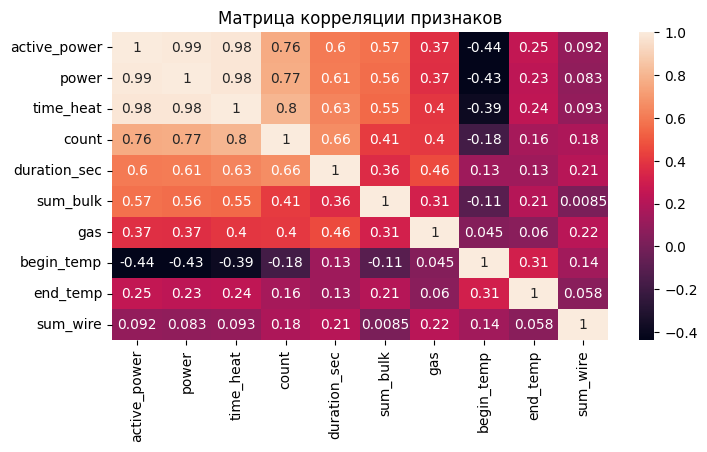

In [209]:
correlation_matrix = df.corr()

plt.figure(figsize= (8, 4))
sns.heatmap(correlation_matrix, annot = True)
plt.title('Матрица корреляции признаков')

Колонка полной энергии сильно коррелирует с активной энергией. СОздам новую колонку с отношением активной энергии к полной и посмотрим, что из этого выйдет.

In [210]:
df['cos_fi'] = df['active_power']/df['power']

In [211]:
df['v_heat'] = df['active_power']/df['time_heat']

Text(0.5, 1.0, 'Матрица корреляции признаков')

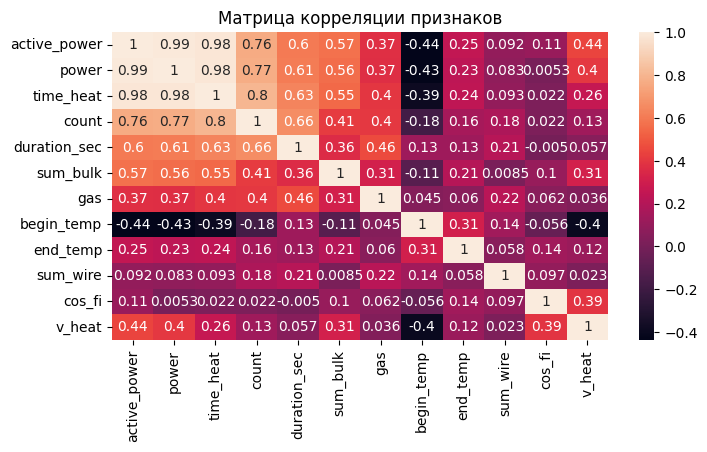

In [212]:
correlation_matrix = df.corr()

plt.figure(figsize= (8, 4))
sns.heatmap(correlation_matrix, annot = True)
plt.title('Матрица корреляции признаков')

Теперь можно не брать полную энергию в моделирование. Время нагрева связано с активной энергией, и поэтому я ввожу ещё один коэффициент - скорость передачи энергии('v_heat').

interval columns not set, guessing: ['active_power', 'power', 'time_heat', 'count', 'duration_sec', 'sum_bulk', 'gas', 'begin_temp', 'end_temp', 'sum_wire', 'cos_fi', 'v_heat']


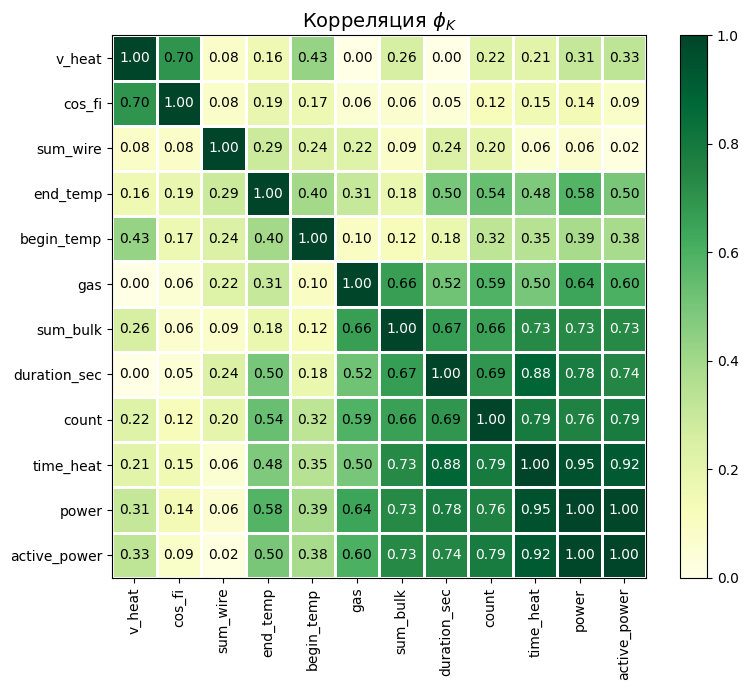

In [213]:
phik_overview = df.phik_matrix() #'insurance_premium', 
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="YlGn", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(8,7))
plt.tight_layout()
plt.show()

Параметр 'duration_sec' - это длительность процесса плавки с учётом пауз между нагревами. Считаю, этот параметр не нужен, потому что нам нужна связь с электричеством, и это нам показывает параметр 'time_heat', который я оставлю ввиде скорости нагрева, потому что у неё меньше корреляций с признаками, чем у времени нагрева. 

In [214]:
df_copy = df.copy()

In [215]:
df = df.drop(['duration_sec', 'power'], axis=1)

In [216]:
df = df.drop(['time_heat'], axis=1)

interval columns not set, guessing: ['active_power', 'count', 'sum_bulk', 'gas', 'begin_temp', 'end_temp', 'sum_wire', 'cos_fi', 'v_heat']


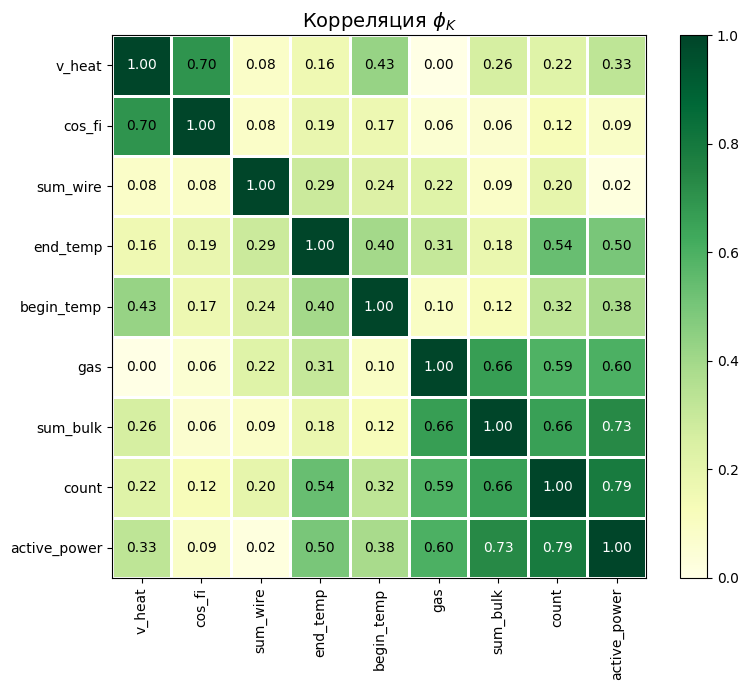

In [217]:
phik_overview = df.phik_matrix() 
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="YlGn", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(8,7))
plt.tight_layout()
plt.show()

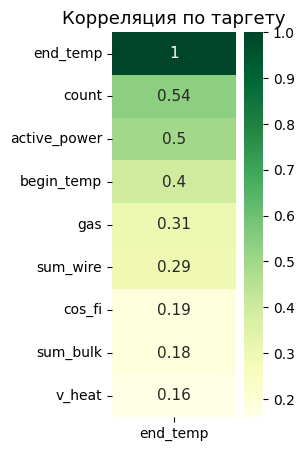

In [218]:
plt.figure(figsize=(2,5))
sns.heatmap(phik_overview.sort_values(by = 'end_temp', ascending=False)[['end_temp']], cmap='YlGn', annot=True, annot_kws={'size':11}, fmt='.2g')
plt.title('Корреляция по таргету', fontsize=13)
plt.show()

Параметры выстроены по важности, и мы видим, что phik считает, что наиболее влиятельные - количество этапов нагрева и активная энергия.

####     Подготовьте данные для обучения:
        Выберите признаки, которые будете использовать для обучения, учитывайте особенности данных и выбранных моделей.
        Разделите данные на тренировочную и тестовую выборки (test_size = 0.25).
        Подготовьте выборки для обучения, учитывайте особенности выбранных моделей.

In [220]:
df.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467],
      dtype='int64', length=2323)

In [221]:
df.reset_index(inplace=True)

In [222]:
df.tail()

,index,active_power,count,sum_bulk,gas,begin_temp,end_temp,sum_wire,cos_fi,v_heat
2318,2463,3.21,4,719.00,7.13,1570.00,1591.00,89.15,0.81,0.00
2319,2464,4.20,6,796.00,9.41,1554.00,1591.00,114.18,0.83,0.00
2320,2465,2.21,3,665.00,6.27,1571.00,1589.00,103.13,0.77,0.00
2321,2466,3.41,5,733.00,14.95,1591.00,1594.00,118.11,0.82,0.00
2322,2467,4.10,4,633.00,11.34,1569.00,1603.00,160.17,0.83,0.00


In [223]:
df = df.drop(['index'], axis=1)

In [224]:
len(df)

2323

In [225]:
y = df['end_temp']

In [226]:
X = df.drop(['end_temp'], axis=1)

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=False,
                                                    random_state=RANDOM_STATE)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1742, 8) (1742,) (581, 8) (581,)


Поскольку все данные у нас числовые, категориальных нет, то просто масштабируем их с помощью StandardScaler.

In [228]:
scaler = StandardScaler().fit(X_train)

                             
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Обучение модели

    Рассмотрите классы моделей:
        решающее дерево или случайный лес,
        бустинги,
        нейронные сети.
    Найдите лучшую модель для прогноза последней измеренной температуры. Оцените её качество метрикой MAE. Выберите лучшую модель по значению метрики на кросс-валидации.
    Подберите значения как минимум двум гиперпараметрам хотя бы для одной модели. Лучше всего использовать методы автоматизированного подбора гиперпараметров: GridSearchCV, RandomizedSearchCV, OptunaSearchCV, Optuna и другие.

In [229]:
rating_table = pd.DataFrame(columns=['mae'])
rating_table

,mae


In [230]:
def add_line_df_score(df_score, model, mean_score):
    
    df_score.loc[model, 'mae'] = "{:.4}".format(mean_score)
    
    return df_score

#### Baseline model

In [237]:
grid_lr = GridSearchCV(LinearRegression(), param_grid={},
                        scoring="neg_mean_absolute_error", cv=5, n_jobs=-1, return_train_score=True)
grid_lr.fit(X_train, y_train)

print('Best score:', round(abs(grid_lr.best_score_), 3))

Best score: 6.738


In [238]:
add_line_df_score(rating_table, 'LinearRegression_baseline', abs(grid_lr.best_score_))

,mae
LinearRegression_baseline,6.738


#### RandomForestRegressor

In [239]:
parameters_forest = {'n_estimators': range(1, 100, 5), 'max_depth' : range(1, 10)}

grid_forest = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE),
                        parameters_forest, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1, return_train_score=True)
grid_forest.fit(X_train, y_train)

print('Best params:', grid_forest.best_params_)
print('Best score:', round(abs(grid_forest.best_score_), 3))


Best params: {'max_depth': 9, 'n_estimators': 91}
Best score: 6.771


In [240]:
model_forest = RandomForestRegressor(max_depth=grid_forest.best_params_.get('max_depth'),
                                      n_estimators=grid_forest.best_params_.get('n_estimators'))

model_forest.fit(X_train, y_train)

predicted_forest = model_forest.predict(X_train)

In [241]:
add_line_df_score(rating_table, 'RandomForestRegressor', abs(grid_forest.best_score_))

,mae
LinearRegression_baseline,6.738
RandomForestRegressor,6.771


#### LGBMRegressor

In [242]:
parameters_lgbm = {
    'max_depth': range(2,20,2),
    'n_estimators': range(1, 100, 10),
    'learning_rate': [0.1, 0.01, 0.04, 0.07]
}
lgbm = LGBMRegressor(seed=RANDOM_STATE, verbose = -1)

grid_lgbm = GridSearchCV(lgbm, parameters_lgbm, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
grid_lgbm.fit(X_train, y_train);
grid_lgbm.best_params_

print('Best params:', grid_lgbm.best_params_)
print('Best score:', "{:.2}".format(abs(grid_lgbm.best_score_)))



Best params: {'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 71}
Best score: 6.7


In [243]:
add_line_df_score(rating_table, 'LGBMRegressor', abs(grid_lgbm.best_score_))

,mae
LinearRegression_baseline,6.738
RandomForestRegressor,6.771
LGBMRegressor,6.708


#### CatBoostRegressor

In [244]:
parameters_cat = {'max_depth' : range(2,6), 
                  'learning_rate': [0.05, 0.075, 0.1], 'iterations': [75, 100, 125, 150, 200, 300, 500]}
grid_cat = GridSearchCV(CatBoostRegressor(random_state=RANDOM_STATE),
                        parameters_cat, scoring="neg_mean_absolute_error",
                        cv=5, n_jobs=-1, return_train_score=True)

grid_cat.fit(X_train, y_train, silent=True)

print('Best params:', grid_cat.best_params_)
print('Best score:', abs(grid_cat.best_score_))

Best params: {'iterations': 200, 'learning_rate': 0.05, 'max_depth': 4}
Best score: 6.7401691796358865


In [245]:
add_line_df_score(rating_table, 'CatBoostRegressor', abs(grid_cat.best_score_))

,mae
LinearRegression_baseline,6.738
RandomForestRegressor,6.771
LGBMRegressor,6.708
CatBoostRegressor,6.74


#### Нейросеть

Поскольку в нейронной сети используются тензоры, переведём данные в этот тип.

In [246]:
X_train_nn = X_train.copy()
y_train_nn = y_train.copy()
X_test_nn = X_test.copy()
y_test_nn = y_test.copy()

In [247]:
X_train_nn = torch.FloatTensor(X_train_nn)
X_train_nn = X_train_nn.to(device)

In [248]:
y_train_nn = torch.FloatTensor(y_train_nn)
y_train_nn = y_train_nn.to(device)

In [249]:
X_test_nn = torch.FloatTensor(X_test_nn)
X_test_nn = X_test_nn.to(device)

In [250]:
y_test_nn = torch.FloatTensor(y_test_nn.to_numpy())
y_test_nn = y_test_nn.to(device)

Создам нейросеть на три слоя.

In [251]:
class Model3(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Model3, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.act4 = nn.ReLU()
        
        nn.init.xavier_uniform_(self.fc1.weight,  gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc2.weight,  gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('relu'))
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        return x    

Функция подбора некоторых параметров.

In [252]:
def learn_model(net, optimizer, num_epochs, batch_size, X_train, y_train, X_test, y_test):
    loss = nn.L1Loss()
    
    num_batches = ceil(len(X_train)/batch_size)
    
    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(X_train)) # случайная перестановка индексов объектов
        
        optimizer.zero_grad()
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
    
            preds = net.forward(X_batch).flatten() 
                
            loss_value = loss(preds, y_batch.flatten())
            loss_value.backward()
            
            if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                
                optimizer.step()
                optimizer.zero_grad()
                
        if epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test).flatten()
            MAE = loss(test_preds, y_test.flatten())
            mae_num = MAE.detach().cpu().numpy()
            
            return  mae_num

In [253]:
def optim(net, lr):
        return torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)

In [254]:
n_in_neurons = X_train.shape[1]
h1 = [16, 32, 64, 128, 256]
h2 = [16, 32, 64, 128, 256]
h3 = [16, 32, 64, 128, 256]
n_out_neurons = 1

In [255]:
num_epochs = 128
batch_size_arr = [128, 64, 256]
accumulation_iteration = 5
lr = 0.1

На небольшом количестве эпох подберём количество нейронов в слоях и размер батча для обучения.

In [256]:
mae3 = []

In [257]:
for batch_size in batch_size_arr:

    for i in range(len(h1)):
        n_hidden_neurons_1 = h1[i]
        for j in range (len(h2)):
            n_hidden_neurons_2 = h2[j]
            for k in range(len(h3)):
                
                n_hidden_neurons_3 = h3[k]

                net = Model3(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
                net.to(device)
                
                optimizer = optim(net, lr)
                mae3.append([n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, type(optimizer), batch_size,
                              learn_model(net, optimizer, num_epochs, batch_size, X_train_nn, y_train_nn, X_test_nn, y_test_nn,)])

In [258]:
mae3 = pd.DataFrame(mae3, columns=['n_hidden_neurons_1', 'n_hidden_neurons_2', 'n_hidden_neurons_3',
                                   'optimizer type','batch_size', 'mae'])


In [259]:
mae3.sort_values('mae').head(1)

,n_hidden_neurons_1,n_hidden_neurons_2,n_hidden_neurons_3,optimizer type,batch_size,mae
143,16,128,128,<class 'torch.optim.adam.Adam'>,64,7.656519


In [260]:
n_hidden_neurons_1_m = list(mae3.sort_values('mae').head(1)['n_hidden_neurons_1'].astype('int64'))[0]
n_hidden_neurons_2_m = list(mae3.sort_values('mae').head(1)['n_hidden_neurons_2'].astype('int64'))[0]
n_hidden_neurons_3_m = list(mae3.sort_values('mae').head(1)['n_hidden_neurons_3'].astype('int64'))[0]
batch_size_m = list(mae3.sort_values('mae').head(1)['batch_size'].astype('int64'))[0]

Лучшие параметры на этом этапе.

In [261]:
print('n_hidden_neurons_1_m', n_hidden_neurons_1_m, 
    '\nn_hidden_neurons_2_m', n_hidden_neurons_2_m,
    '\nn_hidden_neurons_3_m',n_hidden_neurons_3_m,
    '\nbatch_size_m' ,batch_size_m)

n_hidden_neurons_1_m 16 
n_hidden_neurons_2_m 128 
n_hidden_neurons_3_m 128 
batch_size_m 64


Обучим сеть с текущими параметрами и посмотрим, как она справляется.

In [262]:
net = Model3(n_in_neurons, n_hidden_neurons_1_m, n_hidden_neurons_2_m, n_hidden_neurons_3_m, n_out_neurons)
    
net.to(device)
optimizer = optim(net, lr)
loss = nn.L1Loss()
num_batches = ceil(len(X_train)/batch_size)
err_train_log = []
err_test_log = []
for epoch in range(num_epochs):
        
    order = np.random.permutation(len(X_train_nn)) # создайте случайную перестановку индексов объектов
        
    optimizer.zero_grad()
    err_log=[]    
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        # получение индексов текущего батча
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_nn[batch_indexes]
        y_batch = y_train_nn[batch_indexes]
    
        preds = net.forward(X_batch).flatten() 
                
        loss_value = loss(preds, y_batch.flatten())

        err_log.append(loss_value.detach().cpu().numpy())
        
        loss_value.backward()
        
        
        if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                
            optimizer.step()
            optimizer.zero_grad()
                
    if epoch%5 == 0 or epoch == num_epochs - 1:
    
        net.eval()
        err_train_log.append(np.mean(err_log))
        test_preds_first = net.forward(X_test_nn).flatten()
        MAE = loss(test_preds_first, y_test_nn.flatten())
        
        err_test_log.append(MAE.detach().cpu().numpy())
print(MAE.detach().cpu().numpy())

110.74243


In [263]:
min_mae = list(mae3.sort_values('mae').head(1)['mae'].astype('float'))[0]

In [264]:
print('n_hidden_neurons_1_m', n_hidden_neurons_1_m, 
    '\nn_hidden_neurons_2_m', n_hidden_neurons_2_m,
    '\nn_hidden_neurons_3_m',n_hidden_neurons_3_m,
    '\nbatch_size_m' ,batch_size_m,
    '\nmae', min_mae,
    '\ntest mae', MAE.detach().cpu().numpy())

n_hidden_neurons_1_m 16 
n_hidden_neurons_2_m 128 
n_hidden_neurons_3_m 128 
batch_size_m 64 
mae 7.656518936157227 
test mae 110.74243


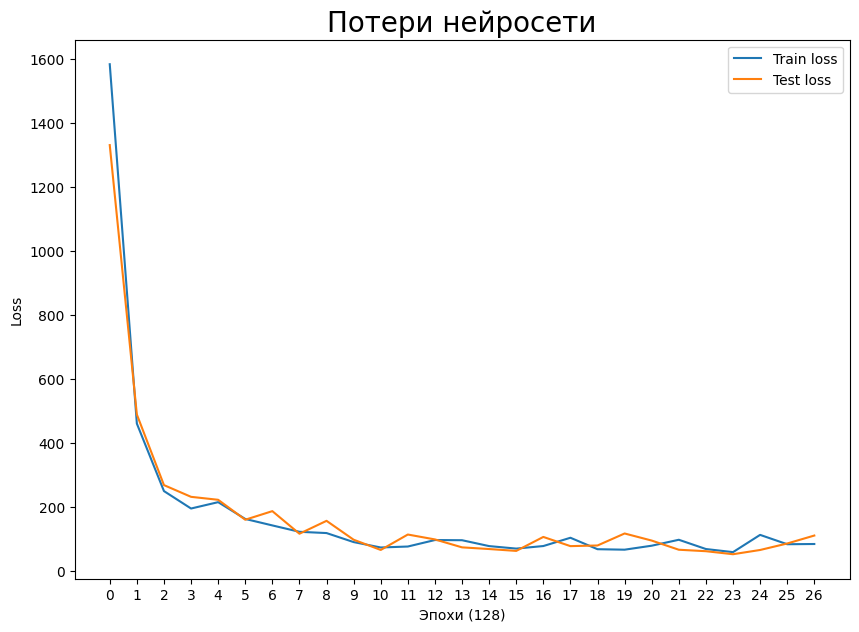

In [265]:
x = np.arange(len(err_train_log))

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(7)
ax.set_xticks(x)
train = ax.plot(x, err_train_log, label = 'Train loss')
test = ax.plot(x, err_test_log, label = 'Test loss')
ax.legend()
ax.set_title('Потери нейросети', fontsize=20)
ax.set_xlabel('Эпохи (128)')
ax.set_ylabel('Loss')
plt.show()

Не достигнута желаемая точность, увеличим точность оптимизации для текущей конфигурации и обучим до нужной точности.

Пробую получить желаемую метрику, увеличивая число эпох.

In [266]:
net = Model3(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)

In [267]:
num_epochs = 8000

In [268]:
net.to(device)
optimizer = optim(net, lr)
loss = nn.L1Loss()
num_batches = ceil(len(X_train_nn)/batch_size)

err_train_log = []
err_test_log = []

order = np.random.permutation(len(X_train_nn)) 
        
optimizer.zero_grad()
err_log=[]

for epoch in range(num_epochs):
        
    order = np.random.permutation(len(X_train_nn)) 
        
    optimizer.zero_grad()
    err_log=[]    
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_nn[batch_indexes]
        y_batch = y_train_nn[batch_indexes]
    
        preds = net.forward(X_batch).flatten() 
                
        loss_value = loss(preds, y_batch.flatten())
        
        err_log.append(torch.sqrt(loss_value).detach().cpu().numpy())
        
        loss_value.backward()
            
        if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
                
            optimizer.step()
            optimizer.zero_grad()
                
    
    net.eval()
    err_train_log.append(np.mean(err_log))
    test_preds = net.forward(X_test_nn).flatten()
    MAE = loss(test_preds, y_test_nn.flatten())
    err_test_log.append(MAE.detach().cpu().numpy())
print(MAE.detach().cpu().numpy())

print(err_train_log[-1])

38.457314
6.662784


In [269]:
MAE = loss(net.forward(X_train_nn).flatten(), y_train_nn.flatten())
print(MAE.detach().cpu().numpy())

37.032593


In [270]:
print('Параметры модели:\nn_hidden_neurons_1_m', n_hidden_neurons_1_m, 
    '\nn_hidden_neurons_2_m', n_hidden_neurons_2_m,
    '\nn_hidden_neurons_3_m',n_hidden_neurons_3_m,
    '\nbatch_size_m' ,batch_size_m,
    '\nlr', lr,
    '\nnum_epochs', num_epochs)

Параметры модели:
n_hidden_neurons_1_m 16 
n_hidden_neurons_2_m 128 
n_hidden_neurons_3_m 128 
batch_size_m 64 
lr 0.1 
num_epochs 8000


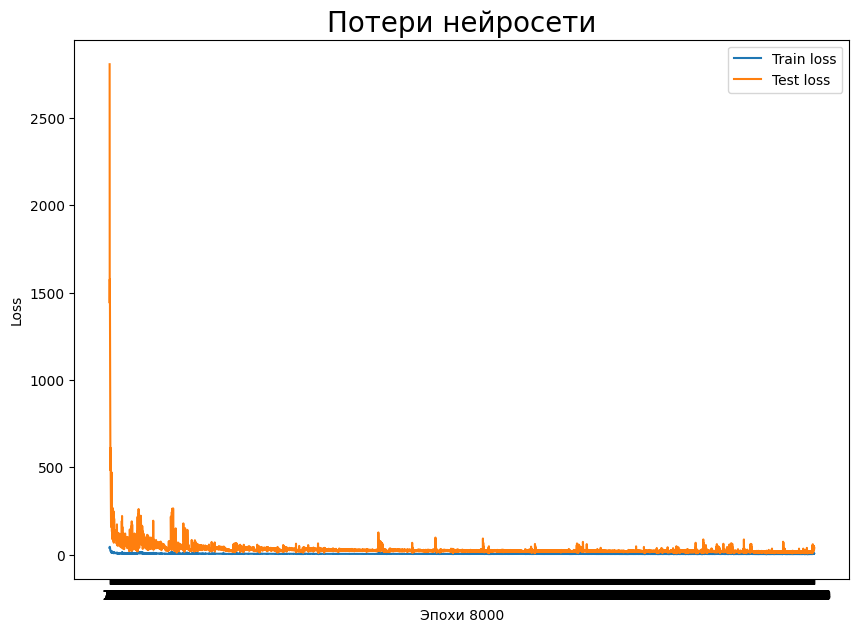

In [271]:
x = np.arange(len(err_train_log))

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(7)
ax.set_xticks(x)
train = ax.plot(x, err_train_log, label = 'Train loss')
test = ax.plot(x, err_test_log, label = 'Test loss')
ax.legend()
ax.set_title('Потери нейросети', fontsize=20)
ax.set_xlabel(f'Эпохи {num_epochs}')
ax.set_ylabel('Loss')
plt.show()

Исходя из динамики метрики, я бы сказала, что эта сеть не подходит вообще к этой задаче. "Забор", как мне кажется, значит, что система не обучается. Не совсем, конечно, ппотому что мы всё-таки наблюдаем снижение диапазона колебаний метрики, но я бы это так интерпретировала. 

In [295]:
add_line_df_score(rating_table, 'NN', MAE.detach().cpu().numpy())

,mae
LinearRegression_baseline,6.738
RandomForestRegressor,6.771
LGBMRegressor,6.708
CatBoostRegressor,6.74
NN,37.03


In [297]:
rating_table.sort_values('mae', ascending=True).style.highlight_min(subset=['mae'])

,mae
NN,37.03
LGBMRegressor,6.708
LinearRegression_baseline,6.738
CatBoostRegressor,6.74
RandomForestRegressor,6.771


### Протестируйте модель и продемонстрируйте её работу

    Проверьте качество лучшей модели на тестовой выборке. Значение метрики MAE должно быть менее 6.8.
    Дополнительно можете оценить R².
    Сравните результаты лучшей и константной моделей.
    Проанализируйте важность основных признаков.
    Для одного из важных признаков проведите дополнительное исследование:
      
        Покажите график зависимости входного и целевого признаков.

LGBMRegressor показал лучшую метрику на обучении.

In [298]:
model_lgbm = LGBMRegressor(max_depth=grid_lgbm.best_params_.get('max_depth'),
                           n_estimators=grid_lgbm.best_params_.get('n_estimators'),
                           learning_rate=grid_lgbm.best_params_.get('learning_rate'),
                           seed=RANDOM_STATE, verbose = -1)
                                                      
model_lgbm.fit(X_train, y_train)
predict_lgbm = model_lgbm.predict(X_test)

In [299]:
print(f'Метрика MAE на тестовых данных = {"{:.3}".format(mean_absolute_error(y_test, predict_lgbm))}')
print(f'Метрика R2 на тестовых данных = {"{:.3}".format(r2_score(y_test, predict_lgbm))}')

Метрика MAE на тестовых данных = 6.66
Метрика R2 на тестовых данных = 0.307


Посмотрим на часть предсказаний, сделанных базовой моделью и LGBMRegressor.

In [300]:
lr_model = grid_lr.best_estimator_
y_test_pred = lr_model.predict(X_test)

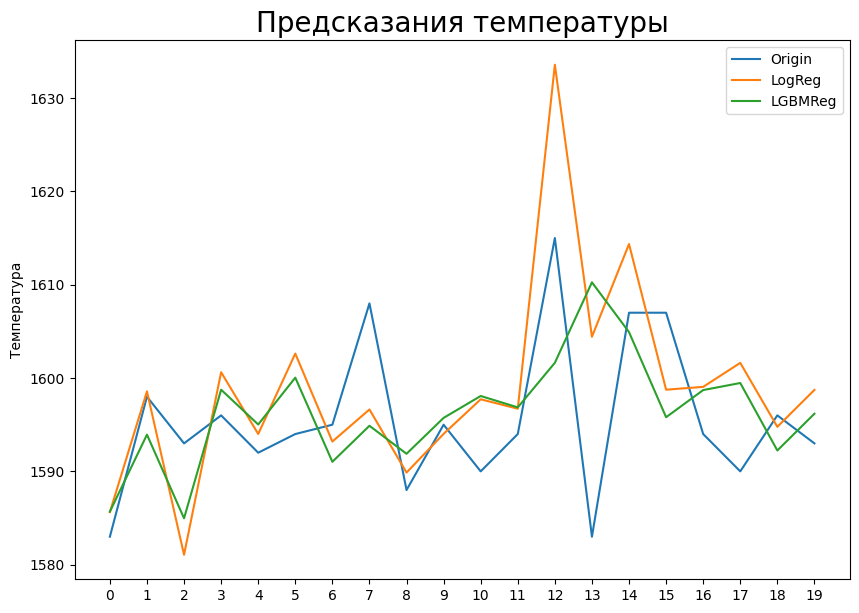

In [301]:
x = np.arange(20)#len(y_test))

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(7)
ax.set_xticks(x)
origin = ax.plot(x, y_test[:20], label = 'Origin')
test_lr = ax.plot(x, y_test_pred[:20], label = 'LogReg')
#test_cat = ax.plot(x, predict_cat[:20], label = 'CatReg')
test_lgbm = ax.plot(x, predict_lgbm[:20], label = 'LGBMReg')
ax.legend()
ax.set_title('Предсказания температуры', fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('Температура')
plt.show()


In [302]:
best_model = model_lgbm

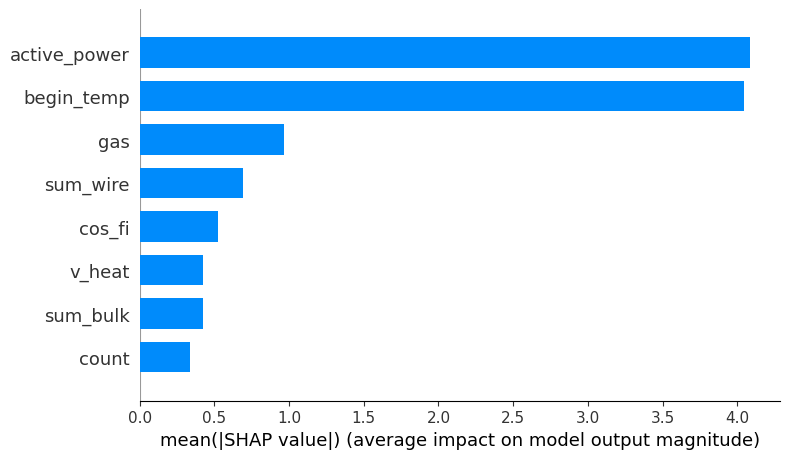

In [303]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train,plot_type="bar", feature_names=X.columns.tolist()) 

Text(0.5, 1.0, 'Важность признаков')

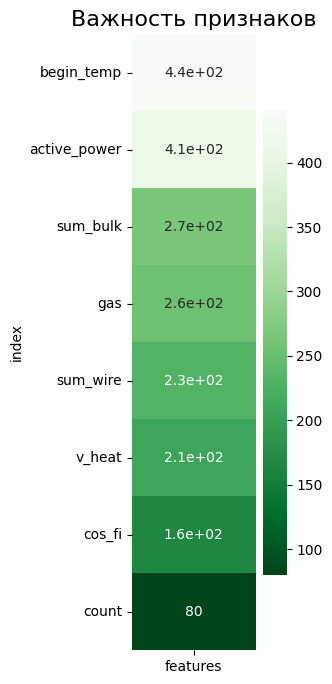

In [304]:
feature_names = X.columns
model_importances = pd.Series(best_model.feature_importances_, index=feature_names).reset_index()
model_importances.index=model_importances['index']
model_importances.rename(columns={0:'features'}, inplace=True)
plt.figure(figsize=(2,8))
sns.heatmap(model_importances[['features']].sort_values(by='features',ascending=False),\
            annot=True, cmap='Greens_r')
plt.title('Важность признаков',fontsize=16)

Два разных способа определения важности признаков указывают на то, что от начальной температуры и активной энергии больше всего зависит конечная температура.

Графически видим, что зависимость трудно определить функционально. Тенденция к росту заметна, но разброс возможных значений велик.

In [305]:
df_temp = df.copy().drop(['active_power', 'v_heat', 'count', 'sum_bulk', 'gas',
                           'sum_wire', 'cos_fi'], axis=1)

Text(0, 0.5, 'Конечная температура')

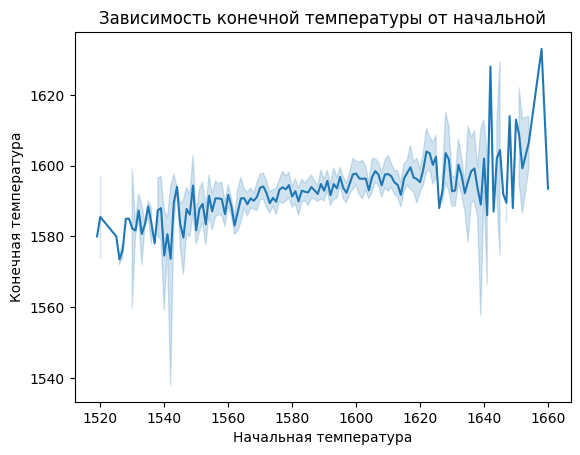

In [306]:
fig, ax = plt.subplots()
sns.lineplot(data=df_temp, x='begin_temp', y='end_temp')

ax.set_title('Зависимость конечной температуры от начальной',fontsize=12)
ax.set_xlabel('Начальная температура')
ax.set_ylabel('Конечная температура')

### Сделайте общий вывод по работе
Напишите общие выводы, предложите способы для дальнейшего улучшения модели и дайте бизнес-рекомендации заказчику.

    Мы провели исследование данных, убрали некорректно зафиксированные партии с аномалиями в значениях и пропусками в необходимых параметрах.
    Обучили разные модели и подобрали лучшую по метрике МАЕ.
    
    Заказчику предложена модель LGBMRegressor с параметрами {'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 71}.
    
    Возможно, существуют модели, которые хорошо справляются с такими разрозненными данными, просто я о них ещё ничего не знаю, или надо ещё интенсивней исследовать уже изученные.
    
    Считаю, что заказчику надо провести исследование КПД теплоотдачи от оборудования к сплаву, возможно, заменить проводники, выбрать более качественные электроды или менее нагревающееся окружение, или попробовать максимально изолировать ёмкость с металлом. В общем, как-то уменьшить теплопотери, увеличив активную мощность без увеличения общей. Также заказчику рекомендуется лучше фиксировать данные, синхронизировать часы на всех датчиках. Может быть, упорядочить технологический процесс, если это возможно.
